## PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

### Temporal Gassusian Process Modelling

This notebook will provide guidance on using Gaussian Process (GP), a nonparametric and Bayesian approach, to infer temporal variation of sea-level change, including magntiude and rate. In a GP, the relationship among any arbitrary set of points (e.g., in time, or in space and time) is a multivariate normal distribution defined by a mean vector and a covariance matrix (or kernel). Compared to using other parametric models (e.g., change-point modelling) to infer time series, GP time-series models have much more flexibility. This is because the shape of the curve is driven by the covariance matrix, which is estimated conditional upon the data, as opposed to a predetermined functional form. 

For GP regression, we should choose a kernel (i.e., covariance matrix) to represent our prior knowledge on the latent process (i.e., sea-level change here). The kernel defines our prior expectations about the variance of the process about its mean and the correlation between points in time (and space), and thus about the way in which information is shared between time points. For modelling sea-level change, the commonly-used kernels are:

**&#10148; 1.** Dot-product

**&#10148; 2.** Rational quadratic

**&#10148; 3.** Squared exponential 

**&#10148; 4.** Matérn  

**&#10148; 5.** Linear

For more information about choosing Gaussian process kernels, check [this blog](https://www.cs.toronto.edu/~duvenaud/cookbook/).

Each kernel contains seveal hyperparameters, which determines predictive performance of the algorithm. Generally, there are two ways to optimize hyperparameters based on the observed data: `Emprical Bayes Analysis` and `Fully Bayesian analysis`. 

Empirical Bayes uses point estimates of the parameters based on the sea level data, which is optimized using maximum likelihood estimate. Therefore this method yields a posterior distribution of sea level conditional on the data and the optimal parameters. 

A fully Bayesian analysis requires that all model hyperparameters have prior probability distributions, allowing hyperparameters to take on a range of probable values. The fully Bayesian method therefore can yield posterior distribution of sea level conditional on the data and posterior distribution of hyperparameters. To sample the prior distribution of hyperparameters, probabilistic sampling approach like Markov Chain Monte Carlo is used, which requires more computational resouces compared to Empirical Bayes. 

The difference between these two method will be demonstrated in this notebook below.


### GP regression on geological sea-level data

For this project, we will focus on using GP regression on geological sea-levle reconstruction. Because geological reconstruction of sea-level change is subject to temporal and vertical uncertainties, different GP models are required to deal with data with different complexities. 

In this notebook we will demonstrate inferring relative sea-level (RSL) change and rate associated with it using New Jersey Holocene relative sea-level data to from [Kemp et al., 2013](https://www.sciencedirect.com/science/article/abs/pii/S0277379113003740), which contains 135 sea-level data point each with: relative sea level, age, relative sea level uncertainty and age uncertainty. GP regressions will be implemented in [pyro framework](pyro.ai), a universal probabilistic programming language written in Python and supported by PyTorch on the backend. 

You can find more background about pyro [here](http://pyro.ai/examples/intro_long), and GP [here](https://distill.pub/2019/visual-exploration-gaussian-processes/). 

Specifically, this notebook will cover: 

&#10148; 1. Inferring sea-level change from data with no temporal uncertainty using one temporal scale GP kernel.

&#10148; 2. Inferring sea-level change from data with no temporal uncertainty using multiple temporal scale GP kernels.

&#10148; 3. Inferring sea-level change from data with data-point-independent temporal uncertainty using multiple temporal scale GP kernels.


In [1]:
#load modules
import os
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import sys
sys.path.append('../')
import PSTHM 
import time
import seaborn as sns
from scipy import interpolate
smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.4')
pyro.set_rng_seed(0) #set random seed used in this notebook

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings("ignore")

In [2]:
def cal_rate_var(test_X,cov_matrix,mean_rsl,difftimestep=200):
    '''A function to caluclate standard deviation of sea-levle change rate (i.e., first derivative of 
    GP).
    ------------------Inputs----------------------------
    test_X: an array of test input values
    cov_matrix: full covariance matrix from GP regression
    mean_rsl: GP regression produced mean RSL prediction
    difftimestep: time period for averaging 
    
    ------------------Outputs---------------------------
    difftimes: time series for the outputs
    rate: averaged sea-level change rate
    rate_sd: averaged sea-level change rate standard deviation
    '''
    
    Mdiff = np.array(np.equal.outer(test_X, test_X.T),dtype=int) - np.array(np.equal.outer(test_X, test_X.T + difftimestep),dtype=int)
    Mdiff = Mdiff * np.equal.outer(np.ones(len(test_X))*1, np.ones(len(test_X)))
    sub = np.where(np.sum(Mdiff, axis=1) == 0)[0]
    Mdiff = Mdiff[sub, :]
    difftimes = np.abs(Mdiff) @ test_X / np.sum(np.abs(Mdiff), axis=1)
    Mdiff = Mdiff / (Mdiff @ test_X.T)[:,None]
    rate_sd = np.sqrt(np.diag(Mdiff @ cov_matrix @ Mdiff.T))
    rate = Mdiff @ mean_rsl
    
    return difftimes,rate, rate_sd

def cal_misfit(y,y_sigma,prediction):
    
    return np.mean(np.sqrt(((y-prediction)/y_sigma)**2))

def cal_likelihood(y,y_std,pred):
    '''A function used to calcualte log likelihood function for a given prediction.
    This calculation only considers uncertainty in y axis. 
    
    ------------Inputs------------------
    y: reconstructed rsl
    y_std: standard deviation of reconstructed rsl
    pred: mean predction of rsl
    
    ------------Outputs------------------
    likelihood: mean likelihood of prediction fit to observation
    '''
    from scipy.stats import norm

    likelihood = 1 
    for i in range(len(y)):
        
        norm_dis = norm(y[i], y_std[i])
        likelihood*=norm_dis.pdf(pred[i])
    likelihood= likelihood/len(y)
    return np.log(likelihood)


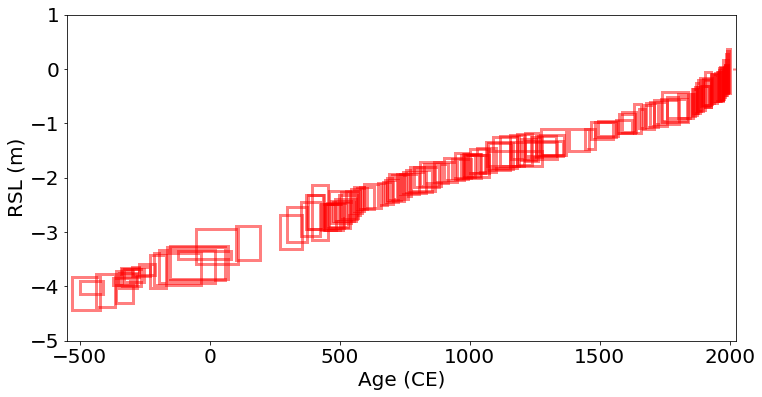

In [3]:
#load data
NJ_data = pd.read_csv('../Data/NJ_CC.csv')
NJ_rsl = NJ_data['RSL']
NJ_rsl_2sd =( NJ_data['RSLer_up_2sd']+NJ_data['RSLer_low_2sd'])/2 #average up and low 2std
NJ_rsl_age = -(NJ_data['Age']-1950) #convert age from BP to CE
NJ_rsl_age_2sd = (NJ_data['Age_low_er_2sd']+NJ_data['Age_up_er_2sd'])/2 #average up and low 2std

#convert RSL data into tonsors
X = torch.tensor(NJ_rsl_age).flatten() #standardise age
y = torch.tensor(NJ_rsl).flatten()
y_sigma = torch.tensor(NJ_rsl_2sd/2).flatten()
x_sigma = torch.tensor(NJ_rsl_age_2sd/2).flatten()

#see the data
ax = PSTHM.plot_uncertainty_boxes(NJ_rsl_age,NJ_rsl, NJ_rsl_age_2sd,NJ_rsl_2sd)
ax.set_xlim(-550,2025)
ax.set_ylim(-5,1)
plt.show();

We can identify from the data that RSL change in New Jersey is non-linear with a potential abrupt RSL rise after 1900s. In this notebook, we will try to use the Gaussian Process Regression method in pyro to replicate the temporal trend of RSL change in [Ashe et al., (2019)](https://www.sciencedirect.com/science/article/pii/S0277379118302130?casa_token=ehTQJ0z-n5UAAAAA:ZsNEE-ycwb8MiHR9pUTq2tjBoT-DjLeyPom7ANILl_euiU1xgyk093UZ7ZYwDc8MWrgMedgh8g#appsec2): 

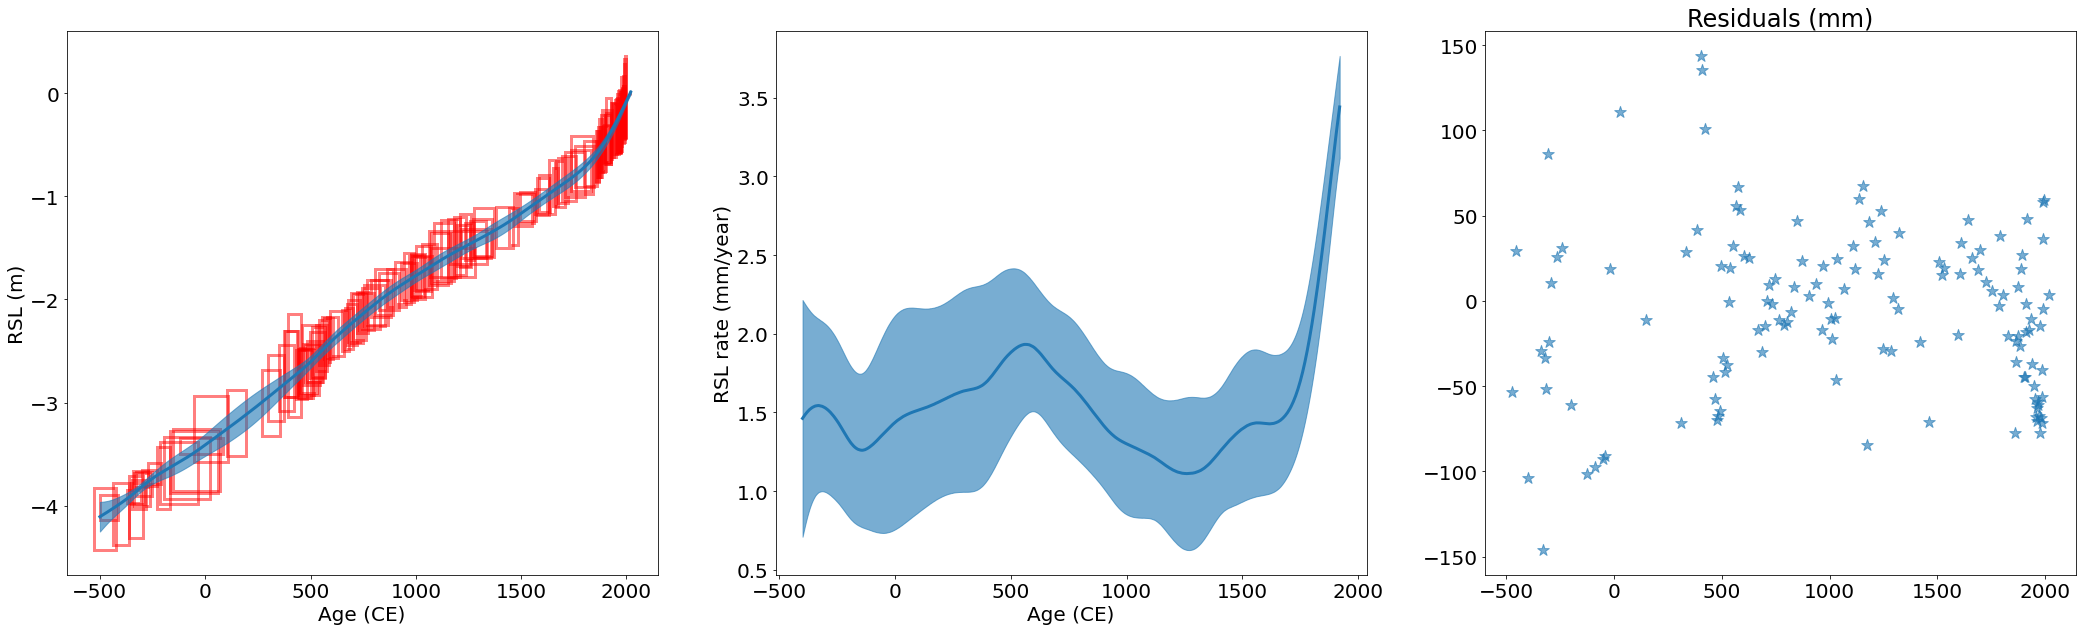

In [4]:
ashe_mean_rsl = np.loadtxt('../Data/ashe_mean.txt')/1000 #convert mm to m
cov_matrix = np.array(pd.read_csv('../Data/ashe_cov.csv',header=None)) 
ashe_sd = np.sqrt(np.diag(cov_matrix))/1000
ashe_rsl_time = np.arange(-500,2025,5.)
rsl_rate_time,ashe_rsl_rate,ashe_rsl_rate_sd = cal_rate_var(ashe_rsl_time,cov_matrix,ashe_mean_rsl)
ashe_rsl_rate_sd/=1000 #convert mm to m

#-----plotting---------
fig= plt.figure(figsize=(36, 10))
ax = plt.subplot(131)
PSTHM.plot_uncertainty_boxes(NJ_rsl_age,NJ_rsl, NJ_rsl_age_2sd,NJ_rsl_2sd,ax=ax)

plt.plot(ashe_rsl_time,ashe_mean_rsl,linewidth=3)
plt.fill_between(
            ashe_rsl_time,  # plot the two-sigma uncertainty about the mean
            (ashe_mean_rsl - 2.0 * ashe_sd),
            (ashe_mean_rsl + 2.0 * ashe_sd),
            color="C0",
            alpha=0.6,zorder=10)

ax = plt.subplot(132)
ax.plot(rsl_rate_time,ashe_rsl_rate*1000,linewidth=3)
ax.fill_between(
            rsl_rate_time,  # plot the two-sigma uncertainty about the mean
            (ashe_rsl_rate - 2.0 * ashe_rsl_rate_sd)*1000,
            (ashe_rsl_rate + 2.0 * ashe_rsl_rate_sd)*1000,
            color="C0",
            alpha=0.6,zorder=10)
plt.xlabel('Age (CE)')
plt.ylabel('RSL rate (mm/year)')


ax = plt.subplot(133)
f_ashe = interpolate.interp1d(ashe_rsl_time,ashe_mean_rsl)
plt.scatter(X,(y-f_ashe(X))*1000,s=150,marker='*',color='C0',alpha=0.6)
plt.title('Residuals (mm)');

### 1. Inferring sea-level change from data with no temporal uncertainty using one temporal scale GP kernel.

We will start with a easy case that we temporaly ignore the age uncertainty, hence we only consider vertical uncertainty from RSL reconstruction here. Additonally, we only use one kernel here, which is capable to capture sea-level process operating in one temporal scale. 

To start with, let's use a linear kernel, which is the same as doing Bayesian linear regression:
$$
k(x,x') = \sigma^2(\text{bias} + x \cdot x')
$$
where $\sigma$ and $bias$ are hyperparameters determines the rate and bias of this linear model. These hyperparamters can be optimized using either Emprical Bayes or Fully Bayesian analysis. 

Empirical Bayes methods are procedures for statistical inference in which the prior probability distribution is estimated from the data. While Fully Bayesian analysis explicitly specifies prior distributions based on prior knowledge or beliefs. Both approaches utilize Bayesian inference, but their emphasis and application contexts differ. For a detailed example of difference between these two method for sea-level research, see [Piecuch et al., (2017)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JC012506).

Here, we start with **empirical Bayes analysis**, where pyro adopts the [Stochastic Variational Inference](https://pyro.ai/examples/svi_part_i.html) method. 


Log Likelihood 1.123
Execution time: 2.131 s


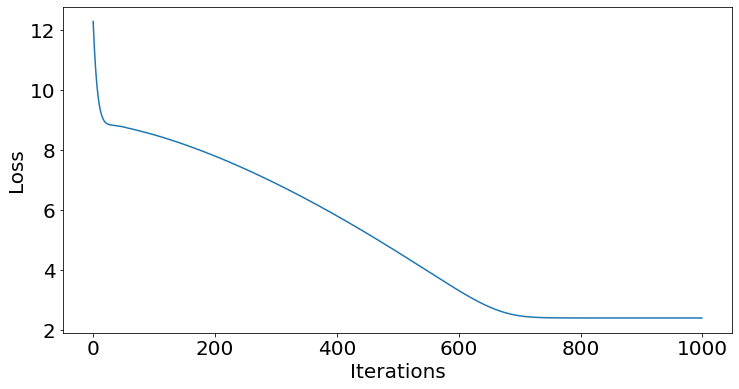

In [5]:
st = time.time() 

pyro.clear_param_store()

#generate a Linear kernel, note degree 1 polynomial kernel is a linear kernel 
Linear_kernel = gp.kernels.Polynomial(input_dim=1,degree=1,bias=torch.tensor(1.),variance=torch.tensor(1.))

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.GPRegression_V(X, y, Linear_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)
gpr = gpr.double()

#optimize RBF kernel with Adam optimizer
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.05)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variance_track,bias_track = [],[]
# likelihoods = []  # List to store the likelihood values
num_steps = 1000 if not smoke_test else 2

for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    likelihood = -loss.item()

    variance_track.append(Linear_kernel.variance.item())
    bias_track.append(Linear_kernel.bias.item())
#plot the loss function 
PSTHM.plot_loss(losses)

#cal misfit
pred_y,_ = gpr(X, full_cov=True)

fit_likelihood = cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Log Likelihood {:3.3f}'.format(fit_likelihood))

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

After 1,000 iteration, we can see the loss function is stationary now, which suggest we have a good estimate of hyperparameters on. We can confrim it by tracking the variation of hyperparameters. 

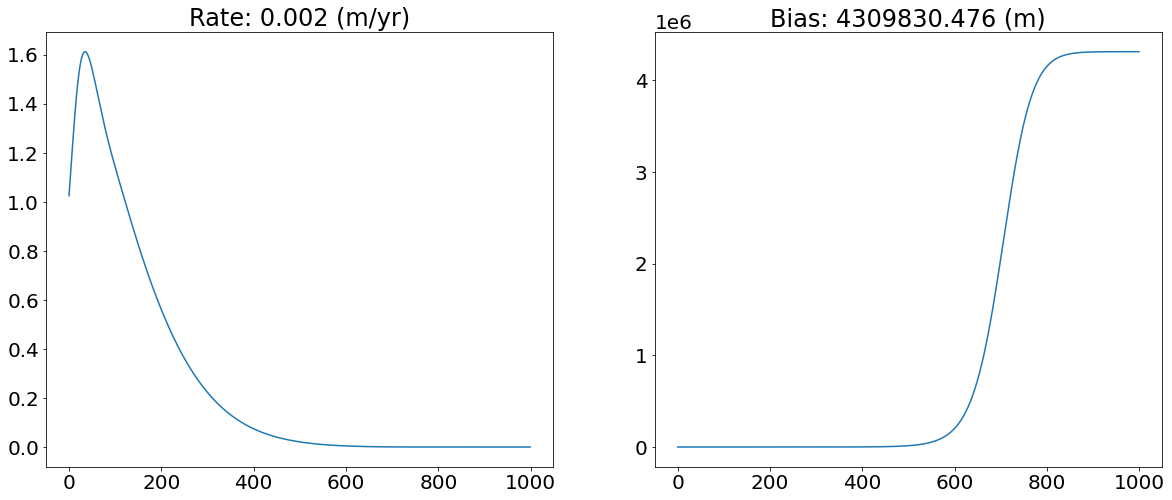

In [6]:
fig= plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.plot(np.arange(len(variance_track)),np.array(variance_track)**0.5)
plt.title('Rate: {:5.3f} (m/yr)'.format(variance_track[-1]**0.5))

plt.subplot(122)
plt.plot(np.arange(len(bias_track)),bias_track)
plt.title('Bias: {:5.3f} (m)'.format(bias_track[-1]));

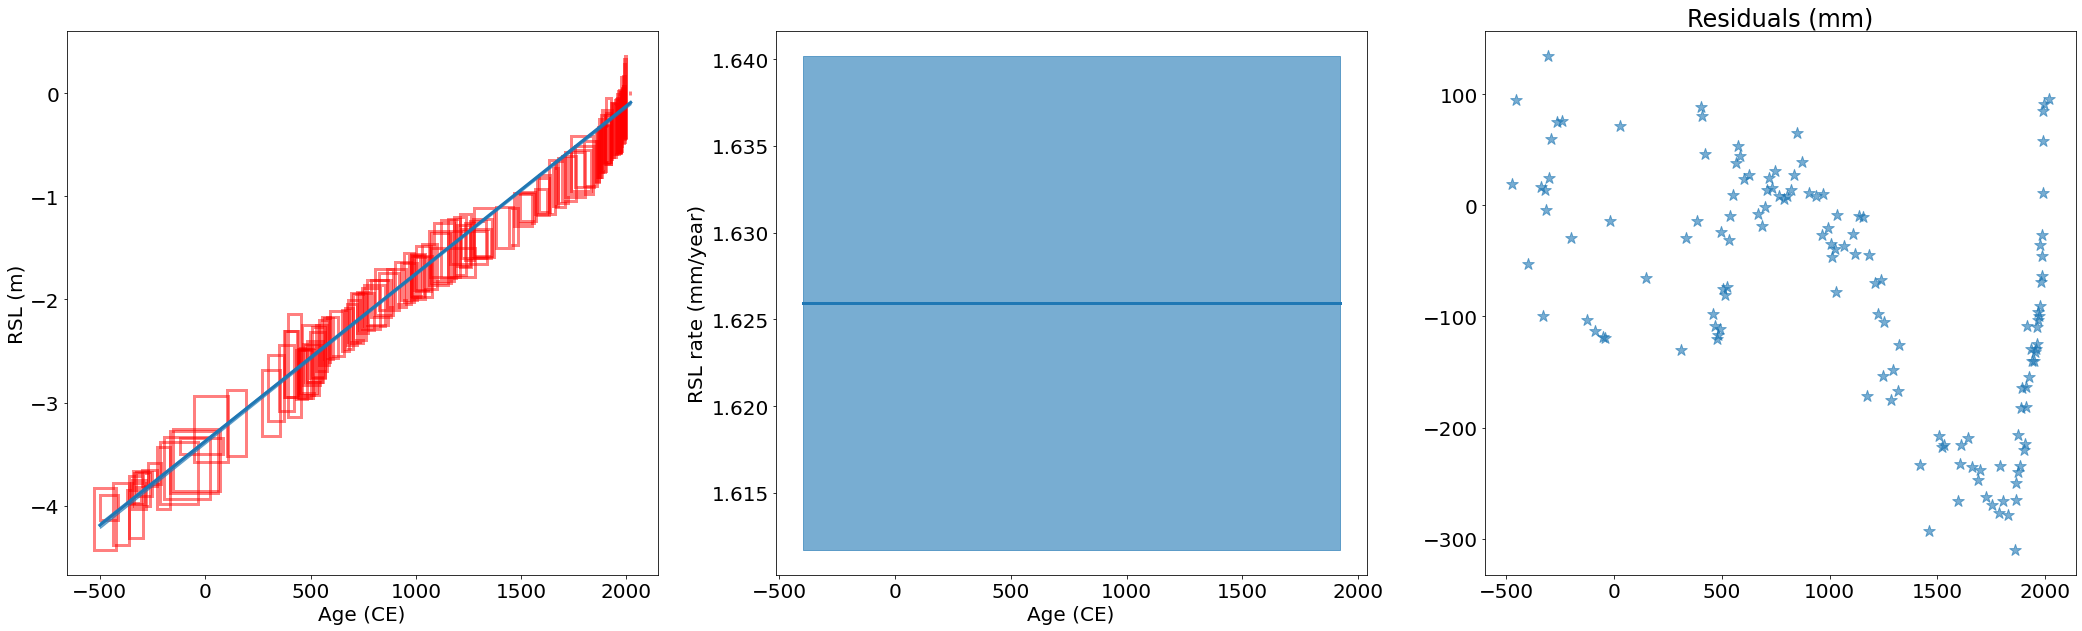

In [7]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5.).type(torch.LongTensor)
y_mean, y_var = gpr(x_test, full_cov=True,noiseless=True)
sd = torch.diag(y_var).sqrt()  # standard deviation at each input point x
rsl_time,rsl_rate,rsl_rate_sd = cal_rate_var(x_test.detach().numpy(),y_var.detach().numpy(),y_mean.detach().numpy())

fig= plt.figure(figsize=(36, 10))
ax = plt.subplot(131)
ax = PSTHM.plot_uncertainty_boxes(NJ_rsl_age,NJ_rsl, NJ_rsl_age_2sd,NJ_rsl_2sd,ax=ax)
plt.plot(x_test.detach().numpy(),y_mean.detach().numpy(),linewidth=3)

ax.fill_between(
            x_test.detach().numpy(),  # plot the two-sigma uncertainty about the mean
            (y_mean - 2.0 * sd).detach().numpy(),
            (y_mean + 2.0 * sd).detach().numpy(),
            color="C0",
            alpha=0.6,zorder=10)
# ax.set_xlim(-3,3)

ax = plt.subplot(132)
plt.plot(rsl_time,rsl_rate*1000,linewidth=3)
ax.fill_between(
            rsl_time,  # plot the two-sigma uncertainty about the mean
            (rsl_rate - 2.0 * rsl_rate_sd)*1000,
            (rsl_rate + 2.0 * rsl_rate_sd)*1000,
            color="C0",
            alpha=0.6,zorder=10)
plt.xlabel('Age (CE)')
plt.ylabel('RSL rate (mm/year)')


ax = plt.subplot(133)
f_ashe = interpolate.interp1d(ashe_rsl_time,ashe_mean_rsl)
plt.scatter(X,(y-pred_y.detach().numpy())*1000,s=150,marker='*',alpha=0.6)

plt.title('Residuals (mm)');


The linear kernel did a fairly good job on fitting the data, and it tells us sea-level rise in New Jersey from -500 CE to present is around 1.63 mm/yr, not bad! But if we look at the residual distribution, we can easily find some temporal structures, indicating this simple parametric linear model fails to capture some temporal variations of sea-level change process here. 

The good thing about GP is that it provides some unparametric kernels to determine RSL change processes without specifying a predetermined functional form, which is much flexible. To demostrate, we start with a squared exponential (i.e., [radial basis kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel)), which is probably the most commonly-used kernel in GP:

$$
k(x,x') = \sigma^2\exp\left(-0.5 \times \frac{|x-x'|^2}{l^2}\right)
$$

where $\sigma$ is an amplitude hyperparameter and $l$ is a length scale hyperparameter. We will optimize these two RBF hyperparameters using empirical Bayes and fully Bayesian analysis.   


Log Likelihood 157.539
Execution time: 2.435 s


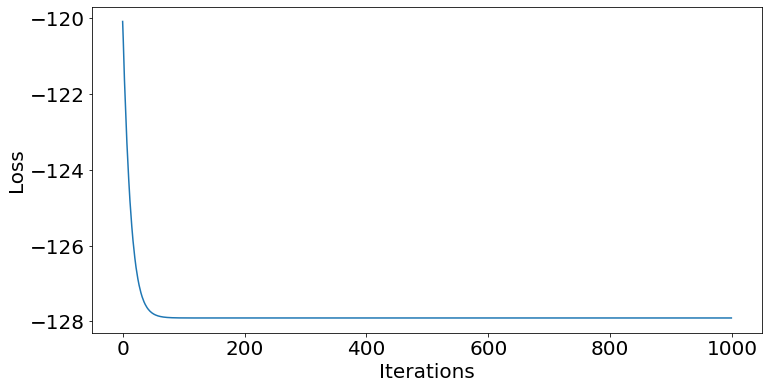

In [8]:
# calculate computational time
st = time.time() 

pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = gp.kernels.RBF(input_dim=1,variance=torch.tensor(1.),lengthscale=torch.tensor(500.))

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.GPRegression_V(X, y, RBF_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)
gpr = gpr.double()

#optimize RBF kernel with Adam optimizer
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.05)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variance_track,lengthscale_track = [],[]
# likelihoods = []  # List to store the likelihood values
testing_y = []
num_steps = 1000 if not smoke_test else 2

for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    likelihood = -loss.item()

    variance_track.append(RBF_kernel.variance.item())
    lengthscale_track.append(RBF_kernel.lengthscale.item())
#plot the loss function 
PSTHM.plot_loss(losses)

#cal misfit
pred_y,_ = gpr(X.double(), full_cov=True)

fit_likelihood = cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Log Likelihood {:3.3f}'.format(fit_likelihood))

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))


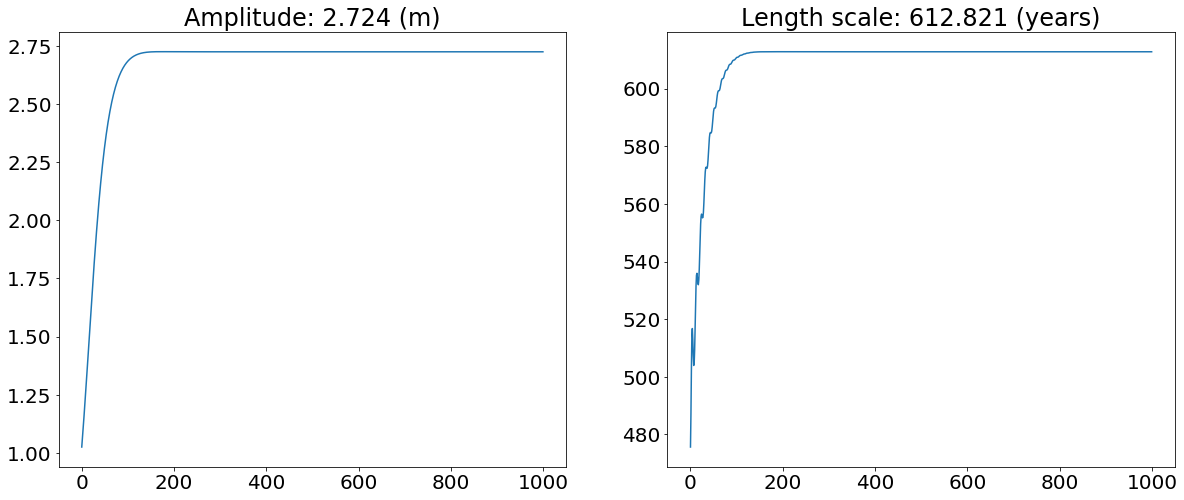

In [9]:
fig= plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.plot(np.arange(len(variance_track)),np.array(variance_track)**0.5)
plt.title('Amplitude: {:5.3f} (m)'.format(variance_track[-1]**0.5))

plt.subplot(122)
plt.plot(np.arange(len(lengthscale_track)),lengthscale_track)
plt.title('Length scale: {:5.3f} (years)'.format(lengthscale_track[-1]));

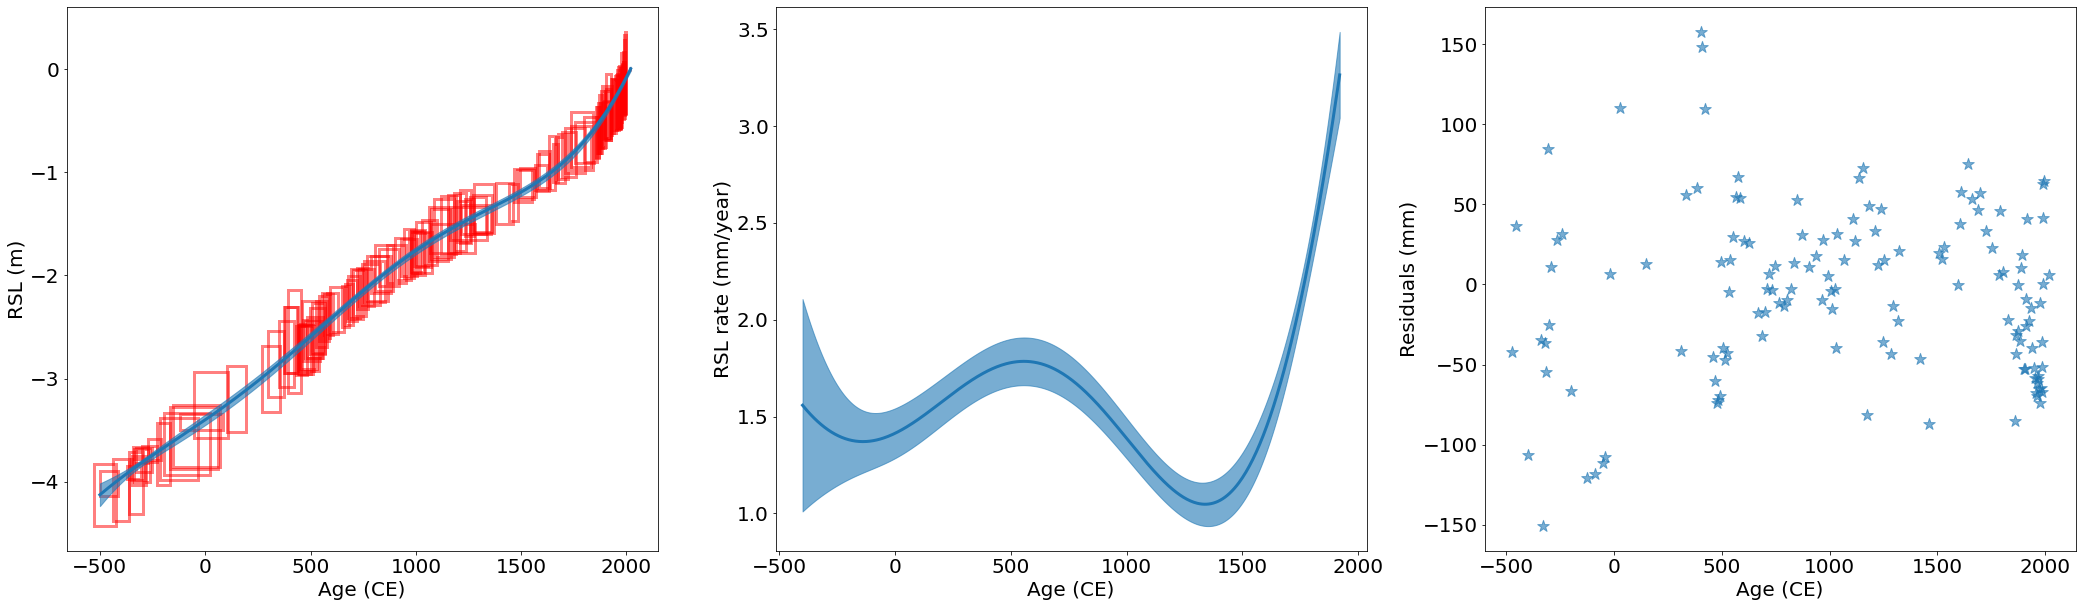

In [19]:

# Make predictions on new inputs
x_test = torch.arange(-500,2025,5.)
y_mean, y_var = gpr(x_test.double(), full_cov=True,noiseless=True)
sd = torch.diag(y_var).sqrt()  # standard deviation at each input point x
rsl_time,rsl_rate,rsl_rate_sd = cal_rate_var(x_test.detach().numpy(),y_var.detach().numpy(),y_mean.detach().numpy())

fig= plt.figure(figsize=(36, 10))
ax = plt.subplot(131)
ax = PSTHM.plot_uncertainty_boxes(NJ_rsl_age,NJ_rsl, NJ_rsl_age_2sd,NJ_rsl_2sd,ax=ax)
plt.plot(x_test.detach().numpy(),y_mean.detach().numpy(),linewidth=3)

ax.fill_between(
            x_test.detach().numpy(),  # plot the two-sigma uncertainty about the mean
            (y_mean - 2.0 * sd).detach().numpy(),
            (y_mean + 2.0 * sd).detach().numpy(),
            color="C0",
            alpha=0.6,zorder=10)
# ax.set_xlim(-3,3)

ax = plt.subplot(132)
plt.plot(rsl_time,rsl_rate*1000,linewidth=3)
ax.fill_between(
            rsl_time,  # plot the two-sigma uncertainty about the mean
            (rsl_rate - 2.0 * rsl_rate_sd)*1000,
            (rsl_rate + 2.0 * rsl_rate_sd)*1000,
            color="C0",
            alpha=0.6,zorder=10)
plt.xlabel('Age (CE)')
plt.ylabel('RSL rate (mm/year)')


ax = plt.subplot(133)
f_ashe = interpolate.interp1d(ashe_rsl_time,ashe_mean_rsl)
plt.scatter(X,(y-pred_y.detach().numpy())*1000,s=150,marker='*',alpha=0.6)
plt.xlabel('Age (CE)')
plt.ylabel('Residuals (mm)');

Based on a RBF kernel, we can start to identify some temporal variation in sea-level change rate. We can easily find out that sea-level rise rate after 1500s started to rise substaintially, and after industrial revolution it increased to a 2000-year high level. Also, the residuals look much more stationary now, the larger residual at older age can be explained by larger sea-level reconstruction uncertainty back in time. 

Now let's try **Fully Bayesian analysis** using [Markov Chain Monte Carlo](https://docs.pyro.ai/en/dev/mcmc.html) based algorithms. Specifically, we will use the No-U Turn Sampler ([NUTS](https://arxiv.org/abs/1111.4246)), which provides an efficient and automated way of running Hamiltonian Monte Carlo. Becuase we define the prior distribution for each hyperparameters, the posterior distributions of hyperparameters by Fully Bayesian analysis incorporated our prior knowledge on a RSL process. Here because we don't have too much prior knowledge, we use non-informative priors (i.e., uniform distribution over a large range).

In [28]:
# calculate computational time
from pyro.infer import MCMC, NUTS, Predictive, HMC
torch.manual_seed(15)
st = time.time() 

pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = gp.kernels.RBF(input_dim=1,variance=torch.tensor(1.),lengthscale=torch.tensor(500.))
#set prior distributions for RBF hyperparameters
RBF_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-3), torch.tensor(1000.)))
RBF_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1.), torch.tensor(3000.)))

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.GPRegression_V(X, y, RBF_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)
gpr = gpr.double()

#generate NUTS sampler 
hmc_kernel = NUTS(gpr.model)
mcmc = MCMC(hmc_kernel, num_samples=1500,warmup_steps=500)
mcmc.run()

# cal misfit
full_b_pred_y,_ = gpr(X.double())

fit_likelihood = cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Log Likelihood {:3.3f}'.format(fit_likelihood))

et = time.time() # get the end time


# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format(elapsed_time))

print('Gelman-Rubin statistic for Lengthscale: {:4.2f}'.format(mcmc.diagnostics()['kernel.lengthscale']['r_hat'].item()))
print('Gelman-Rubin statistic for Varience: {:4.2f}'.format(mcmc.diagnostics()['kernel.variance']['r_hat'].item()))

Warmup:   2%|▏         | 45/2000 [03:59,  5.33s/it, step size=3.54e-06, acc. prob=0.677]

Log Likelihood 157.539
Execution time: 111.773 s
Gelman-Rubin statistic for Lengthscale: 1.01
Gelman-Rubin statistic for Varience: 1.02


For any mcmc based approach, it is important to confirm that each Markov Chain has reached to the stationary stage, meaning it is converged, therefore can well represent the poseterior distribution. A commonly-used approach for assessing this is the Gelman-Rubin statistic, which analyze the difference between multiple Markov chains. The convergence is assessed by comparing the estimated between-chains and within-chain variances for each model parameter. Usually, a < 1.1 Gelman-Rubin statistic declares a good convergence. 

Hence, the hyperparameters aboved should be converged, we can further confirm it by visulising the Markov Chain:


Text(0.5, 0, 'Samples')

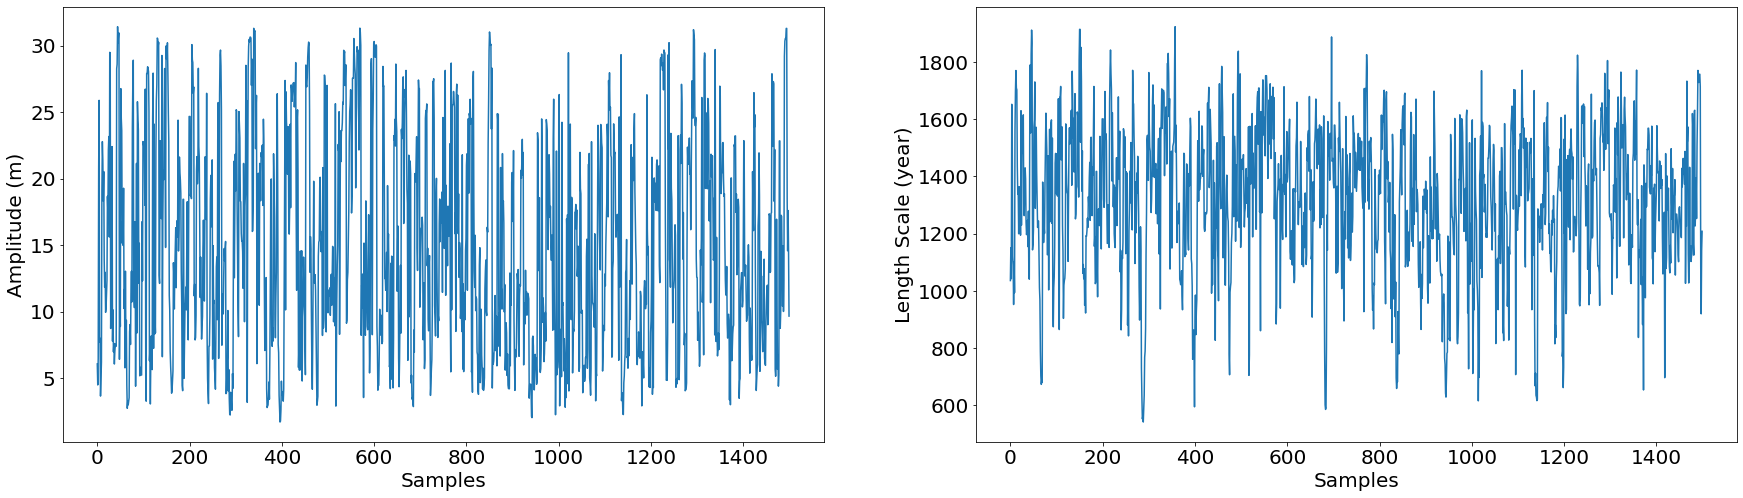

In [29]:
plt.figure(figsize=(30,8))
plt.subplot(121)
plt.plot(torch.arange(len(mcmc.get_samples()['kernel.variance'])),mcmc.get_samples()['kernel.variance']**0.5)
plt.ylabel('Amplitude (m)')
plt.xlabel('Samples')
plt.subplot(122)
plt.plot(torch.arange(len(mcmc.get_samples()['kernel.variance'])),mcmc.get_samples()['kernel.lengthscale'])
plt.ylabel('Length Scale (year)')
plt.xlabel('Samples')


Apart from convergence, we should also assess the correlation between Markov Chains. A good way for testing this is auto-correlation, which measures the degree of similarity between a time series and a lagged version of itself over successive time intervals. 


Auto-Correlation <0.05 from  9


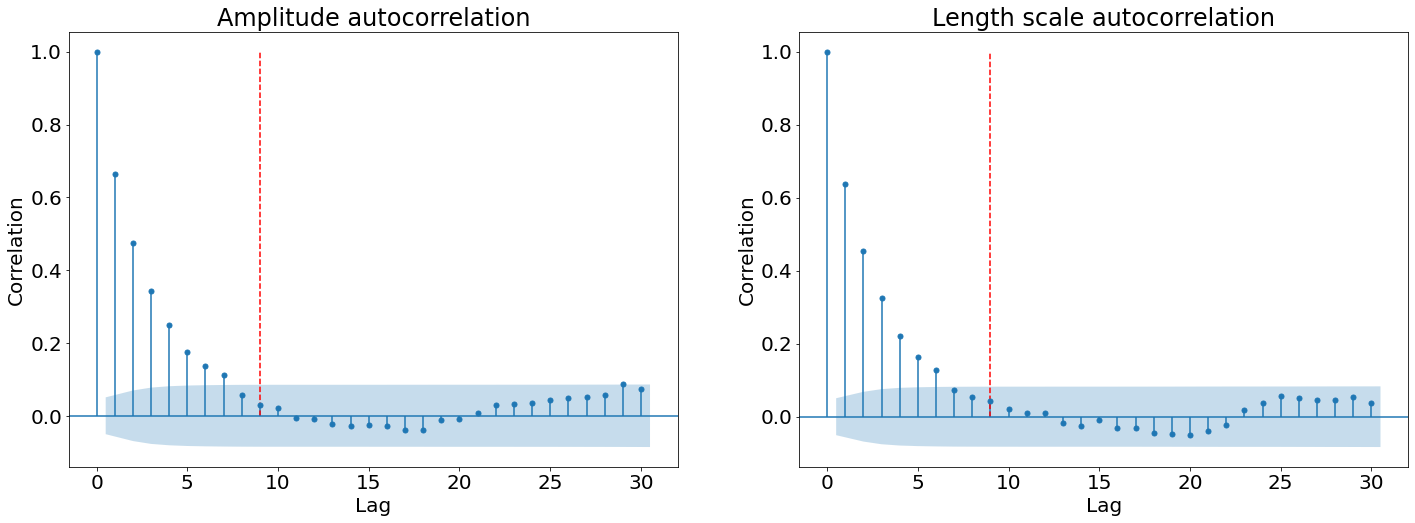

In [30]:
from statsmodels.graphics import tsaplots
import statsmodels.api as sm

#plot autocorrelation function
plt.figure(figsize=(24,8))
ax = plt.subplot(121)
variance_auto = sm.tsa.acf(mcmc.get_samples()['kernel.variance']**0.5)
ls_auto = sm.tsa.acf(mcmc.get_samples()['kernel.lengthscale'])
thin_index = np.argmax((np.abs(variance_auto)<0.05)&(np.abs(ls_auto)<0.05))

tsaplots.plot_acf(mcmc.get_samples()['kernel.variance']**0.5, lags=30,alpha=0.05,ax=ax,title='Amplitude autocorrelation')
ax.vlines(thin_index,0,1,color='r',linestyle='--')
ax.set_xlabel('Lag')
ax.set_ylabel('Correlation')
ax2 = plt.subplot(122)
tsaplots.plot_acf(mcmc.get_samples()['kernel.lengthscale'], lags=30,ax=ax2,alpha=0.05,
                  title='Length scale autocorrelation');
ax2.vlines(thin_index,0,1,color='r',linestyle='--')

ax2.set_xlabel('Lag')
ax2.set_ylabel('Correlation')

print('Auto-Correlation <0.05 from ',thin_index);

Based on the auto-correlation resutls above, we can tell that the resulting Markov Chains show sufficiently low correlation between each 9 posterior samples.  After checking the convergence and correlation status, we can now visulize the posterior distribution of hyperparameters.

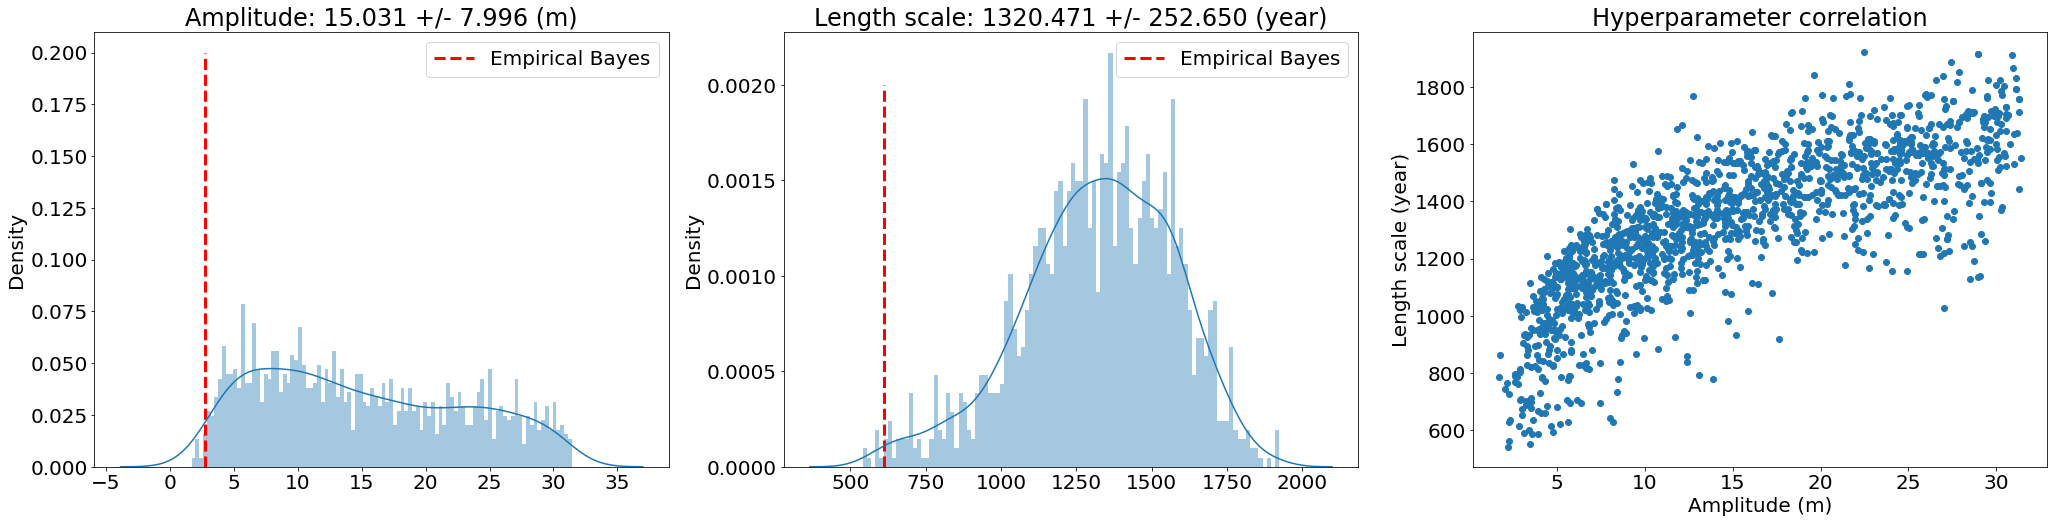

In [31]:
plt.figure(figsize=(35,8))
plt.subplot(131)
sns.distplot(mcmc.get_samples()['kernel.variance']**0.5,bins=100)
plt.vlines(variance_track[-1]**0.5,0,0.20,color='r',linestyle='--',label='Empirical Bayes',linewidth=3)
plt.title('Amplitude: {:5.3f} +/- {:5.3f} (m)'.format(torch.mean(mcmc.get_samples()['kernel.variance']**0.5),
                                            torch.std(mcmc.get_samples()['kernel.variance']**0.5)))
plt.legend()
plt.subplot(132)
sns.distplot(mcmc.get_samples()['kernel.lengthscale'],bins=100)
plt.vlines(lengthscale_track[-1],0,0.002,color='r',linestyle='--',label='Empirical Bayes',linewidth=3)
plt.title('Length scale: {:5.3f} +/- {:5.3f} (year)'.format(torch.mean(mcmc.get_samples()['kernel.lengthscale']),
                                                           torch.std(mcmc.get_samples()['kernel.lengthscale'])));
plt.legend()
plt.subplot(133)
plt.scatter(mcmc.get_samples()['kernel.variance']**0.5,mcmc.get_samples()['kernel.lengthscale'])
plt.xlabel('Amplitude (m)')
plt.ylabel('Length scale (year)')
plt.title('Hyperparameter correlation');


In [15]:
# X_new = torch.arange(-500,2025,5.).double()
# def predictive(X_new):
#     h_new_loc, new_var = gpr(X_new)
#     pyro.sample("y", dist.Normal(h_new_loc,new_var.sqrt()))
    
# #defined thinned mcmc samples
# thin_mcmc = mcmc.get_samples().copy()
# thin_mcmc['kernel.lengthscale'] = thin_mcmc['kernel.lengthscale'].double()
# thin_mcmc['kernel.variance'] = thin_mcmc['kernel.variance'].double()

# posterior_predictive = Predictive(predictive,  thin_mcmc)
# mcmc_ensemble = posterior_predictive.get_samples(X_new)['y'].detach().numpy()
# mcmc_mean = np.mean(mcmc_ensemble,axis=0)
# mcmc_percentile = np.percentile(mcmc_ensemble,[2.5,97.5],axis=0)

# fig= plt.figure(figsize=(24, 10))
# ax = plt.subplot(121)
# ax = PSTHM.plot_uncertainty_boxes(NJ_rsl_age,NJ_rsl, NJ_rsl_age_2sd,NJ_rsl_2sd,ax=ax)
# plt.plot(x_test.detach().numpy(),mcmc_mean,linewidth=3)

# ax.fill_between(
#             x_test.detach().numpy(),  # plot the two-sigma uncertainty about the mean
#             mcmc_percentile[0],
#             mcmc_percentile[1],
#             color="C0",
#             alpha=0.6,zorder=10);

Warmup:   0%|          | 0/2000 [05:33, ?it/s]


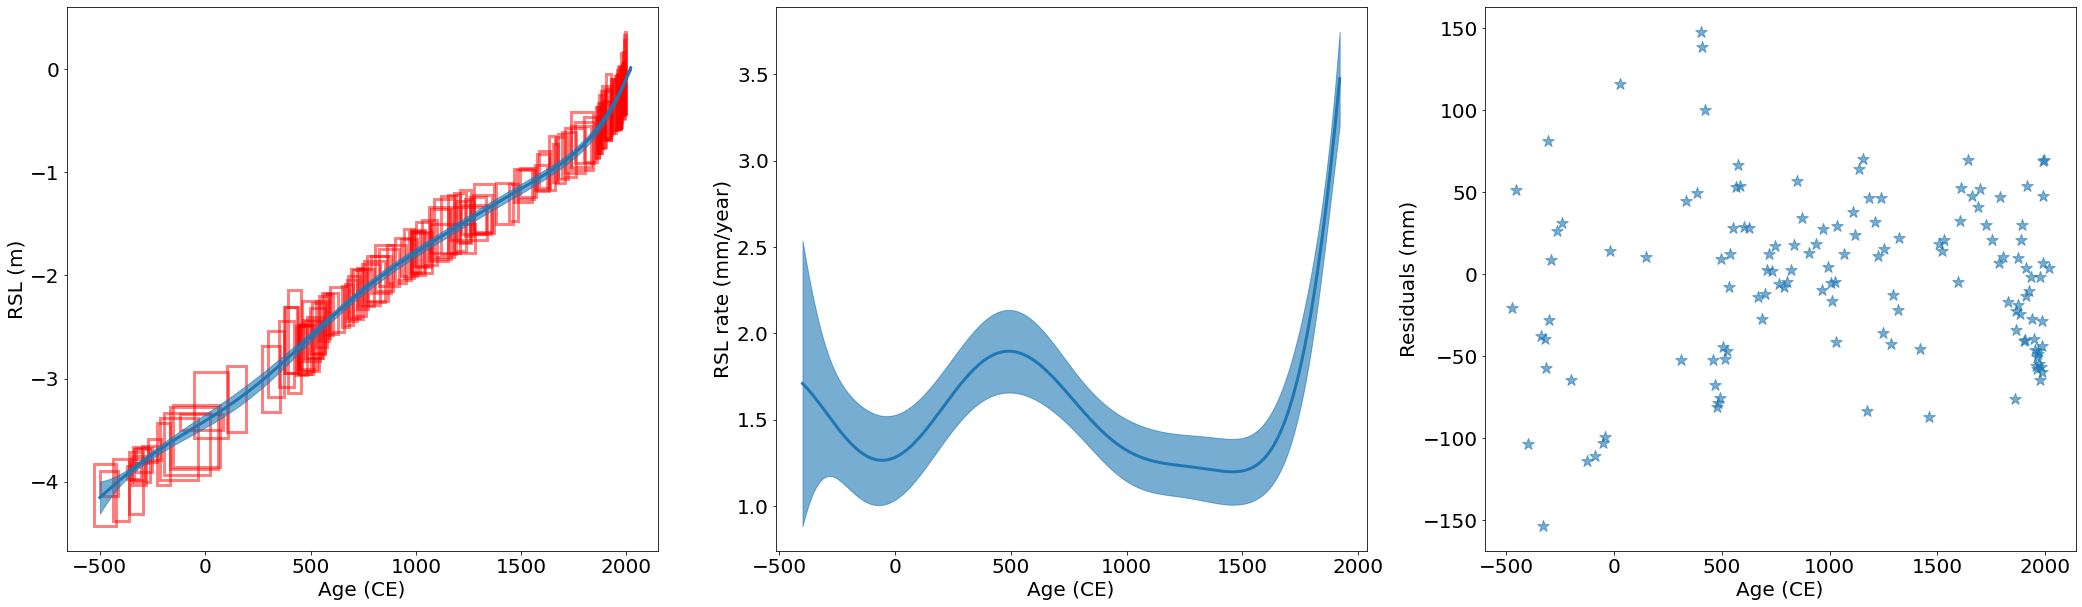

In [32]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5.)
y_mean2, y_var2 = gpr(x_test.double(), full_cov=True,noiseless=True)
sd2 = torch.diag(y_var2).sqrt()  # standard deviation at each input point x
rsl_time,rsl_rate2,rsl_rate_sd2 = cal_rate_var(x_test.detach().numpy(),y_var2.detach().numpy(),y_mean2.detach().numpy())

fig= plt.figure(figsize=(36, 10))
ax = plt.subplot(131)
ax = PSTHM.plot_uncertainty_boxes(NJ_rsl_age,NJ_rsl, NJ_rsl_age_2sd,NJ_rsl_2sd,ax=ax)
plt.plot(x_test.detach().numpy(),y_mean2.detach().numpy(),linewidth=3)

ax.fill_between(
            x_test.detach().numpy(),  # plot the two-sigma uncertainty about the mean
            (y_mean2 - 2.0 * sd2).detach().numpy(),
            (y_mean2 + 2.0 * sd2).detach().numpy(),
            color="C0",
            alpha=0.6,zorder=10)
# ax.set_xlim(-3,3)

ax = plt.subplot(132)
plt.plot(rsl_time,rsl_rate2*1000,linewidth=3)

ax.fill_between(
            rsl_time,  # plot the two-sigma uncertainty about the mean
            (rsl_rate2 - 2.0 * rsl_rate_sd2)*1000,
            (rsl_rate2 + 2.0 * rsl_rate_sd2)*1000,
            color="C0",
            alpha=0.6,zorder=10)
plt.xlabel('Age (CE)')
plt.ylabel('RSL rate (mm/year)')

ax = plt.subplot(133)
f_ashe = interpolate.interp1d(ashe_rsl_time,ashe_mean_rsl)
plt.scatter(X,(y-full_b_pred_y.detach().numpy())*1000,s=150,marker='*',alpha=0.6)

plt.ylabel('Residuals (mm)')
plt.xlabel('Age (CE)');


#### Compare Empirical Bayes with Fully Bayesian anslysis

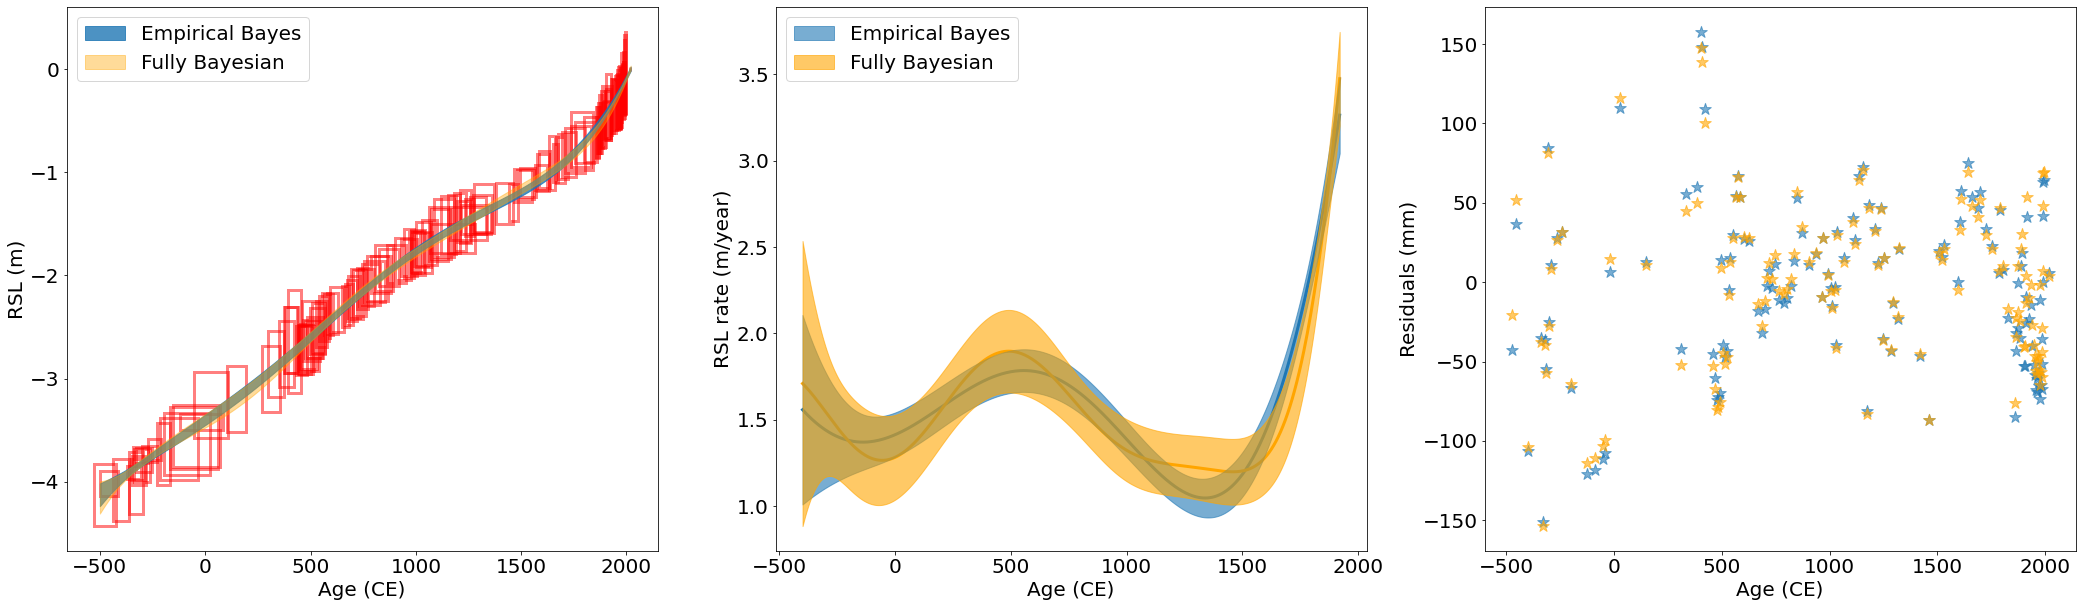

In [33]:
fig= plt.figure(figsize=(36, 10))
ax = plt.subplot(131)
ax = PSTHM.plot_uncertainty_boxes(NJ_rsl_age,NJ_rsl, NJ_rsl_age_2sd,NJ_rsl_2sd,ax=ax)
ax.fill_between(
            x_test.detach().numpy(),  # plot the two-sigma uncertainty about the mean
            (y_mean - 2.0 * sd).detach().numpy(),
            (y_mean + 2.0 * sd).detach().numpy(),
            color="C0",
            alpha=0.8,zorder=10,label='Empirical Bayes')
ax.fill_between(
            x_test.detach().numpy(),  # plot the two-sigma uncertainty about the mean
            (y_mean2 - 2.0 * sd2).detach().numpy(),
            (y_mean2 + 2.0 * sd2).detach().numpy(),
            color="orange",
            alpha=0.4,zorder=10,label='Fully Bayesian')
ax.legend()


ax = plt.subplot(132)
plt.plot(rsl_time,rsl_rate*1000,linewidth=3,color='C0')

ax.fill_between(
            rsl_time,  # plot the two-sigma uncertainty about the mean
            (rsl_rate - 2.0 * rsl_rate_sd)*1000,
            (rsl_rate + 2.0 * rsl_rate_sd)*1000,
            color="C0",
            alpha=0.6,zorder=10,label='Empirical Bayes')

plt.plot(rsl_time,rsl_rate2*1000,linewidth=3,color='orange')

ax.fill_between(
            rsl_time,  # plot the two-sigma uncertainty about the mean
            (rsl_rate2 - 2.0 * rsl_rate_sd2)*1000,
            (rsl_rate2 + 2.0 * rsl_rate_sd2)*1000,
            color="orange",
            alpha=0.6,zorder=10,label='Fully Bayesian')
plt.xlabel('Age (CE)')
plt.ylabel('RSL rate (m/year)')
ax.legend(loc=2)



ax = plt.subplot(133)
plt.scatter(X,(y-pred_y.detach().numpy())*1000,s=150,marker='*',alpha=0.6,label='Empirical Bayes')
plt.scatter(X,(y-full_b_pred_y.detach().numpy())*1000,s=150,marker='*',alpha=0.6,label='Fully Bayesian',color='orange')

plt.ylabel('Residuals (mm)')
plt.xlabel('Age (CE)');

For a single RBF kernel, the Empirical Bayes and Fully Bayesian Analysis seem to show very similar results. Although you might find the posterior distributions of variance and length scale parameters for Fully Bayesian Analysis covers a wide range, but due to the trade-off between variance and length scale parameters (you can easily find a postive correlation between two hyperparameters in the correlation plot above), the resulting predictions are similar. It should be noticed that the prior distributions have hugh impact on the resulting posterior distribution, so make sure you have enough information about the process before putting any informative priors. 

### Alternative kernel function

You might be able to identify that RSL change quite smoothly in the plots above. This is because the nature of RBF kernel, which is infinitely differentiable, indicating it assumes RSL change very smoothly without abrupt change. However, this is usually not the case for sea level as it might rise abruptly due to climate change. 

To improve on this, we can use althernative kernel options that are more flexible. An good example is 3/2 Matérn kernel:

$$
k(x, x') = \sigma^2\left(1 + \sqrt{3} \times \frac{|x-x'|}{l}\right)
        \exp\left(-\sqrt{3} \times \frac{|x-x'|}{l}\right)
$$

similar to RBF kernel above, $\sigma$ is an amplitude hyperparameter and $l$ is a length scale hyperparameter. Becuase 3/2 Matérn kernel is only once differentiable, it allows sea-level to change more abruptly. 

Log Likelihood 159.592
Execution time: 2.691 s


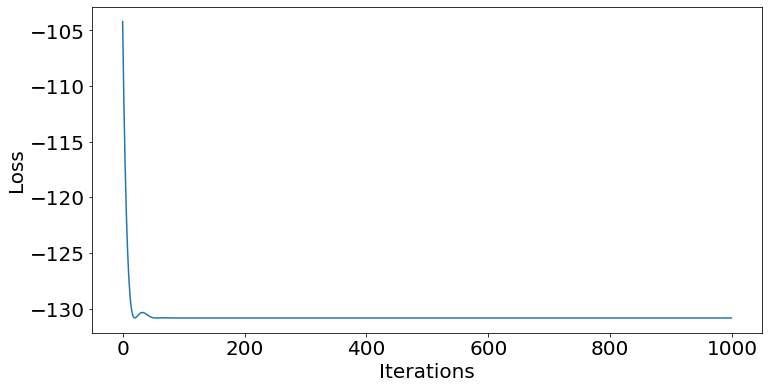

In [34]:
# calculate computational time
st = time.time() 

pyro.clear_param_store()

#generate a Matern32 kernel 
Matern32_kernel = gp.kernels.Matern32(input_dim=1,variance=torch.tensor(10.),lengthscale=torch.tensor(10000.))

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.GPRegression_V(X, y, Matern32_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)
gpr = gpr.double()

#optimize RBF kernel with Adam optimizer
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.05)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variance_track,lengthscale_track = [],[]

num_steps = 1000 if not smoke_test else 2

for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    gpr.set_mode("guide")
    variance_track.append(Matern32_kernel.variance.item())
    lengthscale_track.append(Matern32_kernel.lengthscale.item())
#plot the loss function 
PSTHM.plot_loss(losses)

#cal misfit
pred_y,_ = gpr(X.double(), full_cov=True)

fit_likelihood = cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Log Likelihood {:3.3f}'.format(fit_likelihood))

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

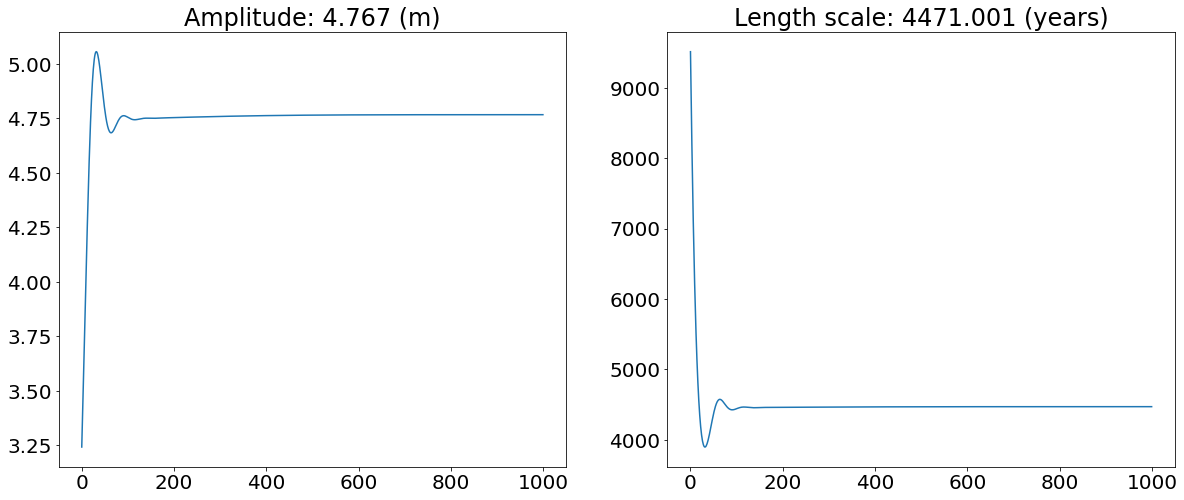

In [35]:
fig= plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.plot(np.arange(len(variance_track)),np.array(variance_track)**0.5)
plt.title('Amplitude: {:5.3f} (m)'.format(variance_track[-1]**0.5))

plt.subplot(122)
plt.plot(np.arange(len(lengthscale_track)),lengthscale_track)
plt.title('Length scale: {:5.3f} (years)'.format(lengthscale_track[-1]));

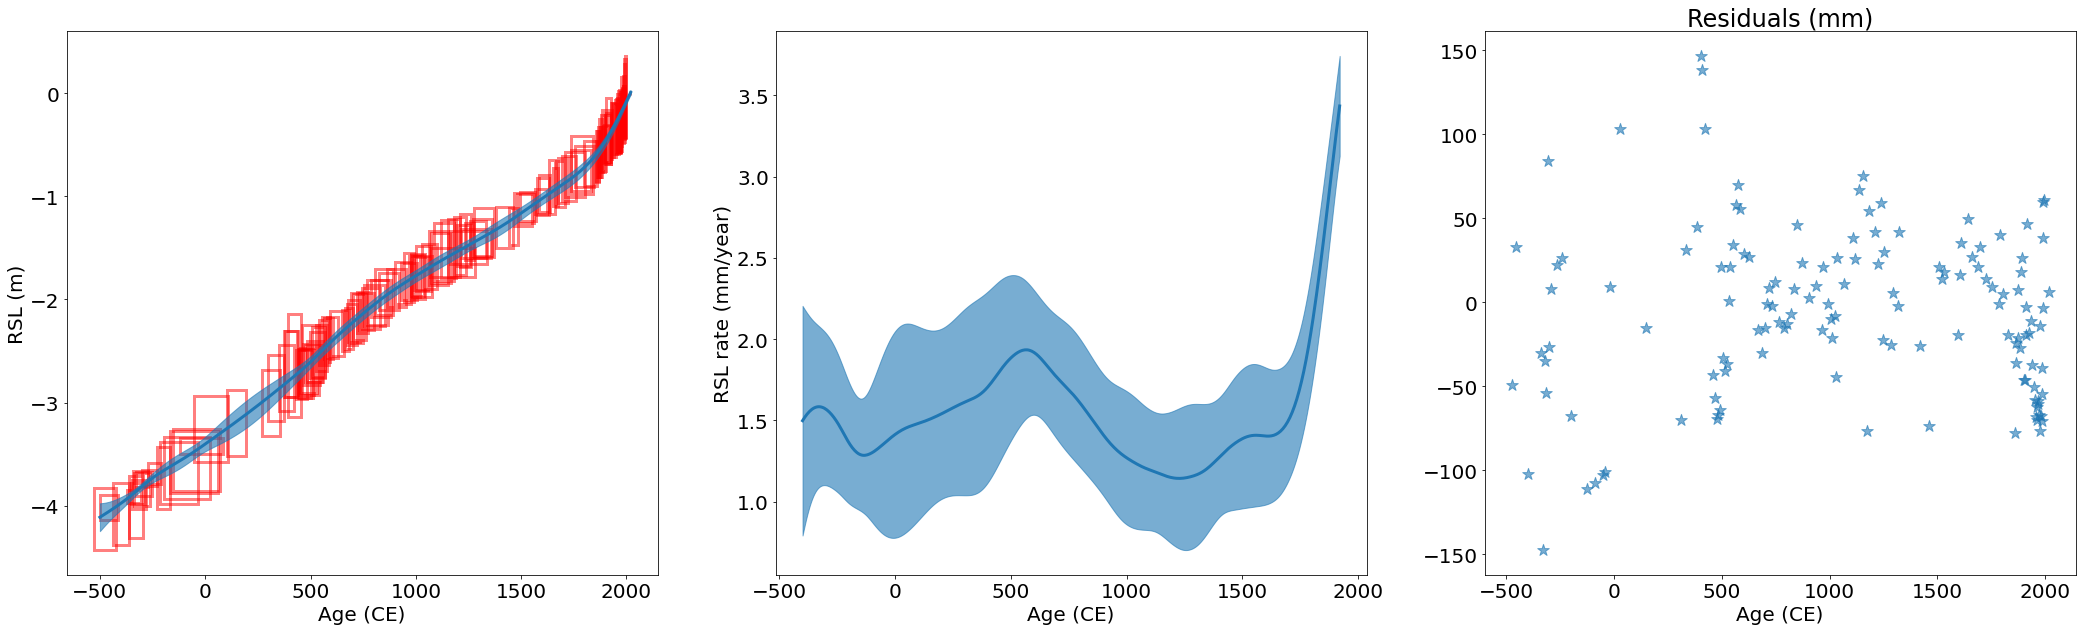

In [41]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5.,requires_grad=True)
Matern32_y_mean, Matern32_y_var = gpr(x_test.double(), full_cov=True,noiseless=True)
Matern32_sd = torch.diag(Matern32_y_var).sqrt()  # standard deviation at each input point x
rsl_time,Matern32_rsl_rate,Matern32_rsl_rate_sd = cal_rate_var(x_test.detach().numpy(),Matern32_y_var.detach().numpy(),Matern32_y_mean.detach().numpy())

fig= plt.figure(figsize=(36, 10))
ax = plt.subplot(131)
ax = PSTHM.plot_uncertainty_boxes(NJ_rsl_age,NJ_rsl, NJ_rsl_age_2sd,NJ_rsl_2sd,ax=ax)
plt.plot(x_test.detach().numpy(),Matern32_y_mean.detach().numpy(),linewidth=3)

ax.fill_between(
            x_test.detach().numpy(),  # plot the two-sigma uncertainty about the mean
            (Matern32_y_mean - 2.0 * Matern32_sd).detach().numpy(),
            (Matern32_y_mean + 2.0 * Matern32_sd).detach().numpy(),
            color="C0",
            alpha=0.6,zorder=10)
# ax.set_xlim(-3,3)

ax = plt.subplot(132)
# plt.plot(x_test.detach().numpy(),y_rate,linewidth=3)
plt.plot(rsl_time,Matern32_rsl_rate*1000,linewidth=3)
ax.fill_between(
            rsl_time,  # plot the two-sigma uncertainty about the mean
            (Matern32_rsl_rate - 2.0 * Matern32_rsl_rate_sd)*1000,
            (Matern32_rsl_rate + 2.0 * Matern32_rsl_rate_sd)*1000,
            color="C0",
            alpha=0.6,zorder=10)
plt.xlabel('Age (CE)')
plt.ylabel('RSL rate (mm/year)')



ax = plt.subplot(133)
plt.scatter(X,(y-pred_y.detach().numpy())*1000,s=150,marker='*',alpha=0.6,label='Empirical Bayes')

plt.title('Residuals (mm)')
plt.xlabel('Age (CE)');

Again, because the 3/2 Matérn kernel is only once differentiable, it is able to capture more short wave-length information and shows higher log likelihood compared with RBF kernel (153.93 vs 153.69), not bad! 

### 2. Inferring sea-level change from data with no temporal uncertainty using multiple temporal scale GP kernels. 

Although the predictions by a single 3/2 Matérn kernel looks better then the RBF kernel, it can still be improved by incorporating multiple kernels. For example, [Ashe et al., (2019)](https://www.sciencedirect.com/science/article/pii/S0277379118302130?casa_token=ehTQJ0z-n5UAAAAA:ZsNEE-ycwb8MiHR9pUTq2tjBoT-DjLeyPom7ANILl_euiU1xgyk093UZ7ZYwDc8MWrgMedgh8g) use a 3/2 Matérn kernel with large variance and length scale hyperparameters to represent global sea-level change trend along with a 3/2 Matérn kernel with medium variance and length scale to indicate regional sea-level variance. Additionally, they also include a white-noise kernel to reflect local RSL signal/noise:
$$
k(x,x') = \sigma^2 \delta(x, x')
$$
where $\delta$ is a Dirac delta function and $\sigma$ is an amplitude hyperparameter.

This can be done in pyro by setting the prior distribution for different hyperparameters for different kernels. Let's try this!


Likelihood 159.293
Execution time: 4.919 s


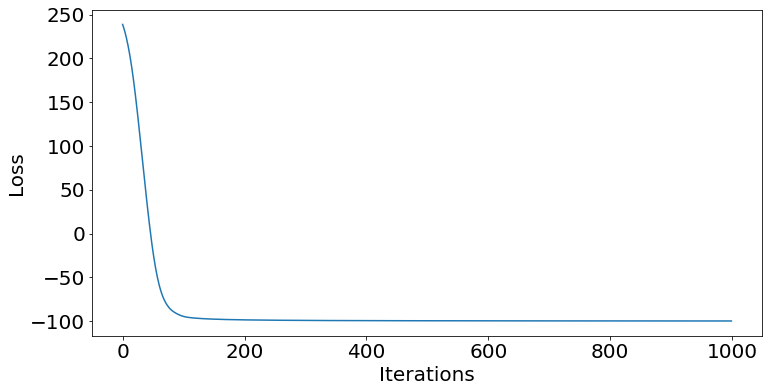

In [42]:
# calculate computational time
st = time.time() 

pyro.clear_param_store()


#generate kernels 
Matern32_kernel = gp.kernels.Matern32(
    input_dim=1,variance=torch.tensor(60**2),lengthscale=torch.tensor(12000))
Matern32_kernel.set_prior("variance", dist.Uniform(torch.tensor(1.), torch.tensor(500.)))
Matern32_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(2000.), torch.tensor(200000.)))

Matern32_kernel2 = gp.kernels.Matern32(
    input_dim=1)
Matern32_kernel2.set_prior("variance", dist.Uniform(torch.tensor(0.01), torch.tensor(40.)))
Matern32_kernel2.set_prior("lengthscale", dist.Uniform(torch.tensor(100.), torch.tensor(2000.)))


Whitenoise_kernel = gp.kernels.WhiteNoise(
    input_dim=1, variance=torch.tensor(1))
Whitenoise_kernel.set_prior('variance', dist.Uniform(torch.tensor(1e-3**2), torch.tensor(2**2)))

combined_kernel = gp.kernels.Sum(Matern32_kernel, Matern32_kernel2)
combined_kernel = gp.kernels.Sum(combined_kernel, Whitenoise_kernel)

gpr = PSTHM.GPRegression_V(X, y, combined_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)
gpr = gpr.double()
#optimize RBF kernel with Adam optimizer
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.1)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variance_track,lengthscale_track = [],[]
variance_track2,lengthscale_track2 = [],[]

num_steps = 1000 if not smoke_test else 2

for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    gpr.set_mode("guide")
    variance_track.append(Matern32_kernel.variance.item())
    variance_track2.append(Matern32_kernel2.variance.item())

    lengthscale_track.append(Matern32_kernel.lengthscale.item())
    lengthscale_track2.append(Matern32_kernel2.lengthscale.item())
#plot the loss function 
PSTHM.plot_loss(losses)

#cal misfit
pred_y,_ = gpr(X.double(), full_cov=True)

fit_likelihood = cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Likelihood {:3.3f}'.format(fit_likelihood))

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

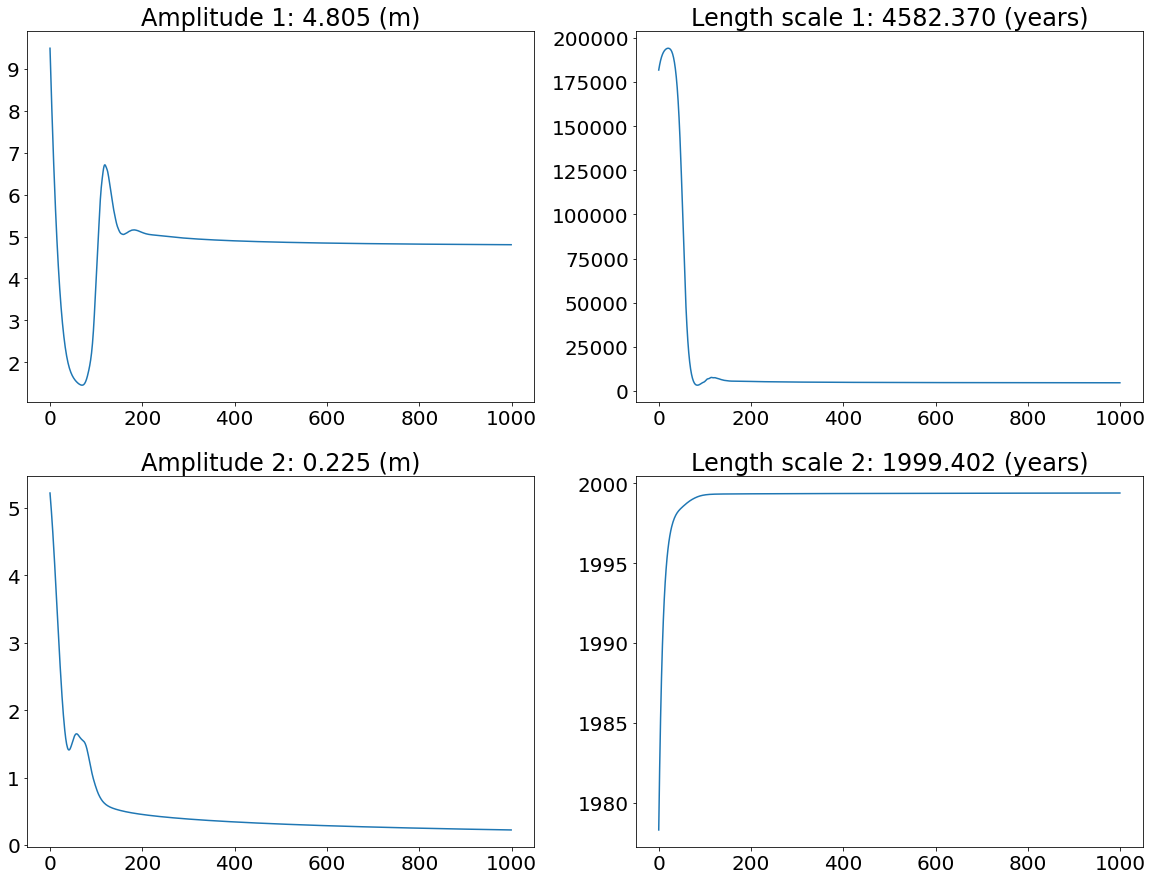

In [43]:
fig= plt.figure(figsize=(20, 15))
plt.subplot(221)
plt.plot(np.arange(len(variance_track)),np.array(variance_track)**0.5)
plt.title('Amplitude 1: {:5.3f} (m)'.format(variance_track[-1]**0.5))

plt.subplot(222)
plt.plot(np.arange(len(lengthscale_track)),lengthscale_track)
plt.title('Length scale 1: {:5.3f} (years)'.format(lengthscale_track[-1]))

plt.subplot(223)
plt.plot(np.arange(len(variance_track)),np.array(variance_track2)**0.5)
plt.title('Amplitude 2: {:5.3f} (m)'.format(variance_track2[-1]**0.5))

plt.subplot(224)
plt.plot(np.arange(len(lengthscale_track)),lengthscale_track2)
plt.title('Length scale 2: {:5.3f} (years)'.format(lengthscale_track2[-1]));

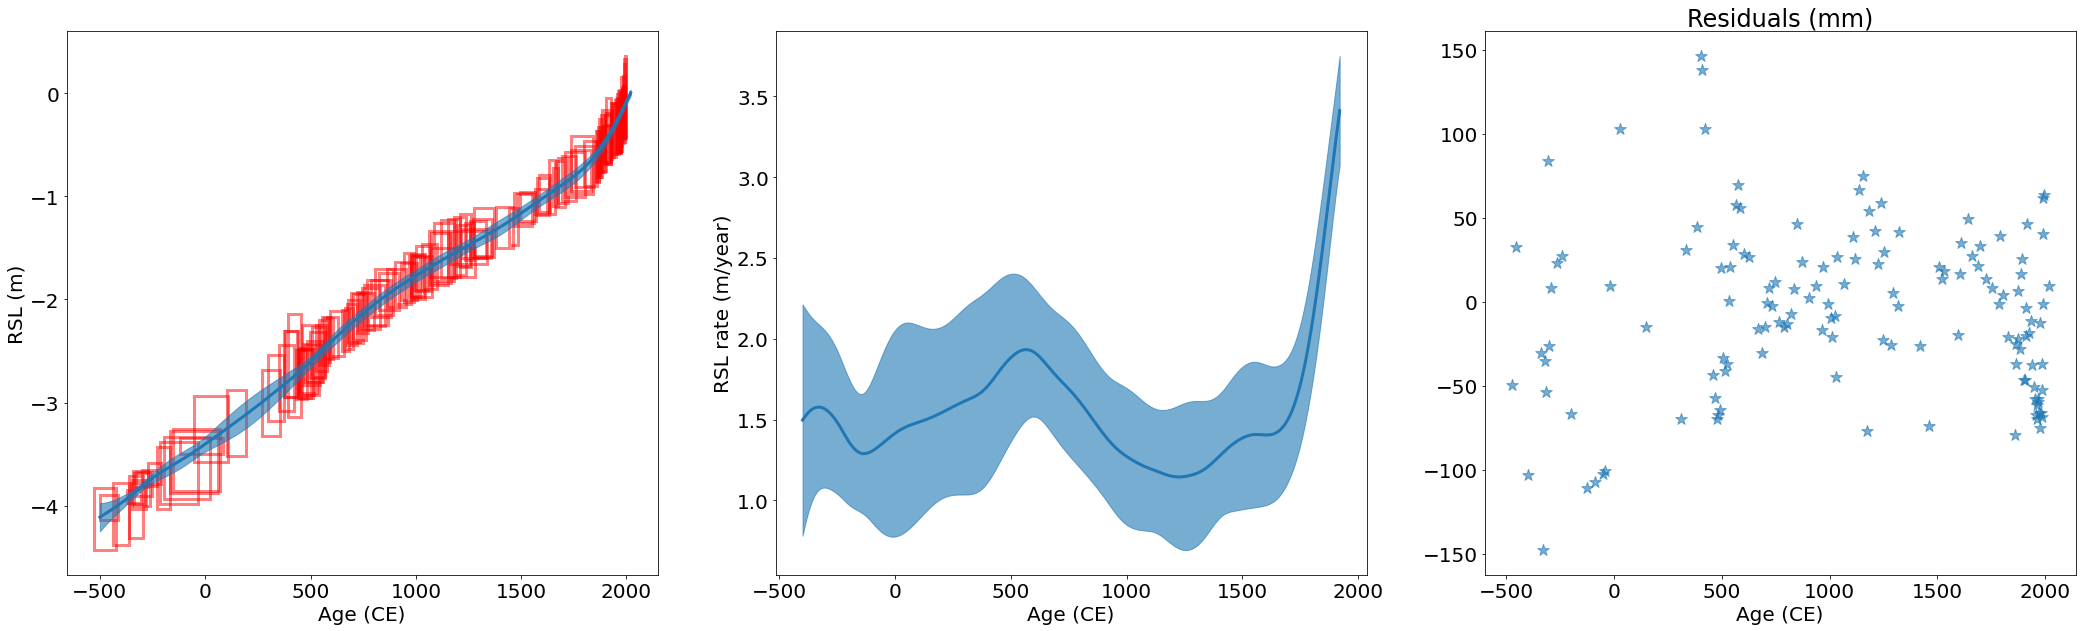

In [44]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5.,requires_grad=True)
c_kernel_y_mean, c_kernel_y_var = gpr(x_test.double(), full_cov=True,noiseless=True)
c_kernel_sd = torch.diag(c_kernel_y_var).sqrt()  # standard deviation at each input point x
rsl_time,c_kernel_rsl_rate,c_kernel_rsl_rate_sd = cal_rate_var(x_test.detach().numpy(),c_kernel_y_var.detach().numpy(),c_kernel_y_mean.detach().numpy())

fig= plt.figure(figsize=(36, 10))
ax = plt.subplot(131)
ax = PSTHM.plot_uncertainty_boxes(NJ_rsl_age,NJ_rsl, NJ_rsl_age_2sd,NJ_rsl_2sd,ax=ax)
plt.plot(x_test.detach().numpy(),c_kernel_y_mean.detach().numpy(),linewidth=3)

ax.fill_between(
            x_test.detach().numpy(),  # plot the two-sigma uncertainty about the mean
            (c_kernel_y_mean - 2.0 * c_kernel_sd).detach().numpy(),
            (c_kernel_y_mean + 2.0 * c_kernel_sd).detach().numpy(),
            color="C0",
            alpha=0.6,zorder=10)
# ax.set_xlim(-3,3)

ax = plt.subplot(132)
# plt.plot(x_test.detach().numpy(),y_rate,linewidth=3)
plt.plot(rsl_time,c_kernel_rsl_rate*1000,linewidth=3)
ax.fill_between(
            rsl_time,  # plot the two-sigma uncertainty about the mean
            (c_kernel_rsl_rate - 2.0 * c_kernel_rsl_rate_sd)*1000,
            (c_kernel_rsl_rate + 2.0 * c_kernel_rsl_rate_sd)*1000,
            color="C0",
            alpha=0.6,zorder=10)
plt.xlabel('Age (CE)')
plt.ylabel('RSL rate (m/year)')


ax = plt.subplot(133)
plt.scatter(X,(y-pred_y.detach().numpy())*1000,s=150,marker='*',alpha=0.6,label='Empirical Bayes')

plt.title('Residuals (mm)')
plt.xlabel('Age (CE)');

### 3. Inferring sea-level change from data with data-point-independent temporal uncertainty using multiple temporal scale GP kernels.

Ok, one thing we keep ignoring is the temporal uncertainty. One easy way to incorporate temporal uncertainty in GP regression is noisy-input GP, introduced by [McHutchon and Rasmussen (2011)](https://proceedings.neurips.cc/paper_files/paper/2011/file/a8e864d04c95572d1aece099af852d0a-Paper.pdf), where temporal uncertainty can be translated into equivalent RSL uncertainty based on squared gradient of the GP posterior mean. The code below is the same as the code above, the only difference is we furhter considering the temporal uncertainty for each RSL data based on RSL gradient calculated above. 

In [45]:
#calculate the RSL gradient from the GP regression defined above
#the rsl rate here is calculaetd using the auto-differentiation function from torch
x_test = torch.tensor(X.clone().float(),requires_grad=True)
y_mean, y_var = gpr(x_test.double(), full_cov=False)
y_mean.sum().backward(retain_graph=True)
y_rate = x_test.grad.detach().numpy()
new_sigma = np.sqrt((y_rate**2*(x_sigma.detach().numpy())**2)+y_sigma.detach().numpy()**2)
# plt.scatter(X,new_sigma**2)
# plt.scatter(X,y_sigma**2)

Likelihood 159.203
Execution time: 7.533 s


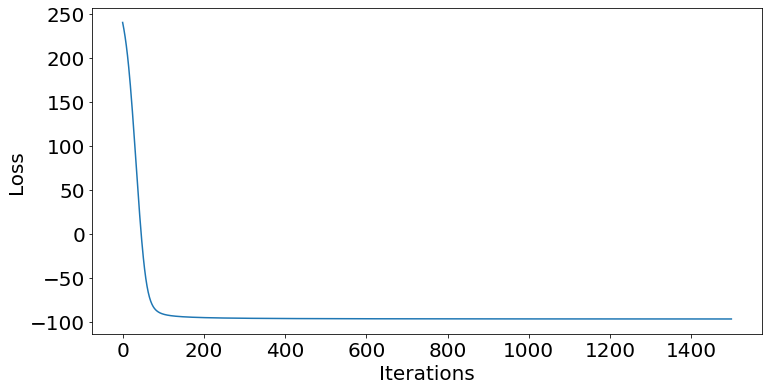

In [48]:
# calculate computational time
st = time.time() 

pyro.clear_param_store()


#generate kernels
Matern32_kernel = gp.kernels.Matern32(
    input_dim=1,variance=torch.tensor(60**2),lengthscale=torch.tensor(12000))
Matern32_kernel.set_prior("variance", dist.Uniform(torch.tensor(1.), torch.tensor(500.)))
Matern32_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(2000.), torch.tensor(200000.)))

Matern32_kernel2 = gp.kernels.Matern32(
    input_dim=1)
Matern32_kernel2.set_prior("variance", dist.Uniform(torch.tensor(0.01), torch.tensor(40.)))
Matern32_kernel2.set_prior("lengthscale", dist.Uniform(torch.tensor(100.), torch.tensor(2000.)))


Whitenoise_kernel = gp.kernels.WhiteNoise(
    input_dim=1, variance=torch.tensor(1))
Whitenoise_kernel.set_prior('variance', dist.Uniform(torch.tensor(1e-3**2), torch.tensor(2**2)))

combined_kernel = gp.kernels.Sum(Matern32_kernel, Matern32_kernel2)
combined_kernel = gp.kernels.Sum(combined_kernel, Whitenoise_kernel)

#****here we use the new sigma instead of y_sigma above!!****
gpr = PSTHM.GPRegression_V(X, y, combined_kernel,noise=torch.tensor(new_sigma**2),jitter=1e-5)
gpr = gpr.double()
#optimize RBF kernel with Adam optimizer
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.1)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variance_track,lengthscale_track = [],[]
variance_track2,lengthscale_track2 = [],[]

num_steps = 1500 if not smoke_test else 2

for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    gpr.set_mode("guide")
    variance_track.append(Matern32_kernel.variance.item())
    variance_track2.append(Matern32_kernel2.variance.item())

    lengthscale_track.append(Matern32_kernel.lengthscale.item())
    lengthscale_track2.append(Matern32_kernel2.lengthscale.item())
#plot the loss function 
PSTHM.plot_loss(losses)

#cal misfit
pred_y,_ = gpr(X.double(), full_cov=True)

fit_likelihood = cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Likelihood {:3.3f}'.format(fit_likelihood))

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

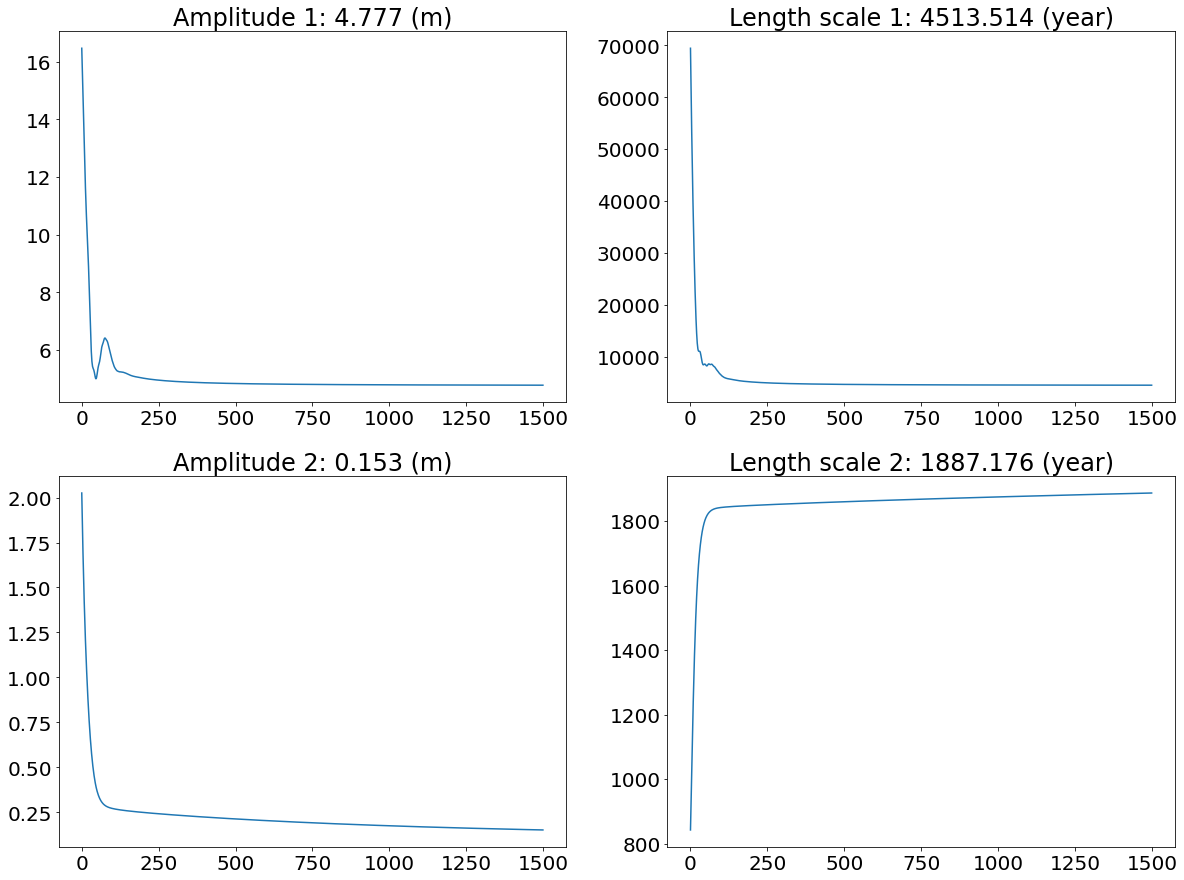

In [49]:
fig= plt.figure(figsize=(20, 15))
plt.subplot(221)
plt.plot(np.arange(len(variance_track)),np.array(variance_track)**0.5)
plt.title('Amplitude 1: {:5.3f} (m)'.format(variance_track[-1]**0.5))

plt.subplot(222)
plt.plot(np.arange(len(lengthscale_track)),lengthscale_track)
plt.title('Length scale 1: {:5.3f} (year)'.format(lengthscale_track[-1]))

plt.subplot(223)
plt.plot(np.arange(len(variance_track)),np.array(variance_track2)**0.5)
plt.title('Amplitude 2: {:5.3f} (m)'.format(variance_track2[-1]**0.5))

plt.subplot(224)
plt.plot(np.arange(len(lengthscale_track)),lengthscale_track2)
plt.title('Length scale 2: {:5.3f} (year)'.format(lengthscale_track2[-1]));

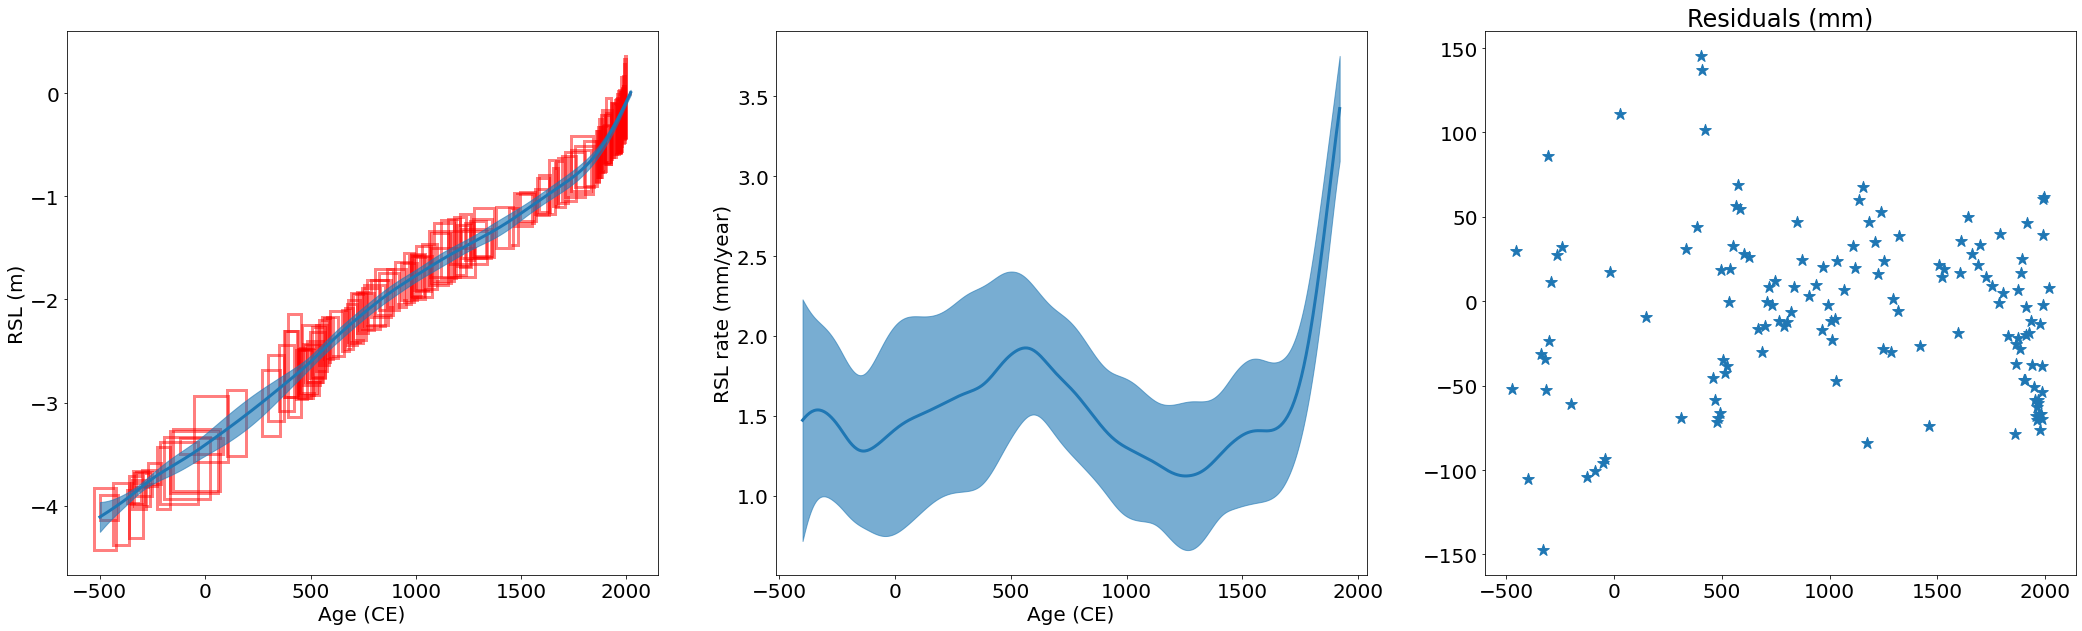

In [50]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5.,requires_grad=True)
c_kernel_y_mean, c_kernel_y_var = gpr(x_test.double(), full_cov=True,noiseless=True)
c_kernel_sd = torch.diag(c_kernel_y_var).sqrt()  # standard deviation at each input point x
rsl_time,c_kernel_rsl_rate,c_kernel_rsl_rate_sd = cal_rate_var(x_test.detach().numpy(),c_kernel_y_var.detach().numpy(),c_kernel_y_mean.detach().numpy())

fig= plt.figure(figsize=(36, 10))
ax = plt.subplot(131)
ax = PSTHM.plot_uncertainty_boxes(NJ_rsl_age,NJ_rsl, NJ_rsl_age_2sd,NJ_rsl_2sd,ax=ax)
plt.plot(x_test.detach().numpy(),c_kernel_y_mean.detach().numpy(),linewidth=3)

ax.fill_between(
            x_test.detach().numpy(),  # plot the two-sigma uncertainty about the mean
            (c_kernel_y_mean - 2.0 * c_kernel_sd).detach().numpy(),
            (c_kernel_y_mean + 2.0 * c_kernel_sd).detach().numpy(),
            color="C0",
            alpha=0.6,zorder=10)
# ax.set_xlim(-3,3)

ax = plt.subplot(132)
# plt.plot(rsl_time,y_rate*1000,linewidth=3)
plt.plot(rsl_time,c_kernel_rsl_rate*1000,linewidth=3)
ax.fill_between(
            rsl_time,  # plot the two-sigma uncertainty about the mean
            (c_kernel_rsl_rate - 2.0 * c_kernel_rsl_rate_sd)*1000,
            (c_kernel_rsl_rate + 2.0 * c_kernel_rsl_rate_sd)*1000,
            color="C0",
            alpha=0.6,zorder=10)
plt.xlabel('Age (CE)')
plt.ylabel('RSL rate (mm/year)')

ax = plt.subplot(133)
plt.scatter(X,(y-pred_y.detach().numpy())*1000,s=150,marker='*')
plt.title('Residuals (mm)');

### Comparison

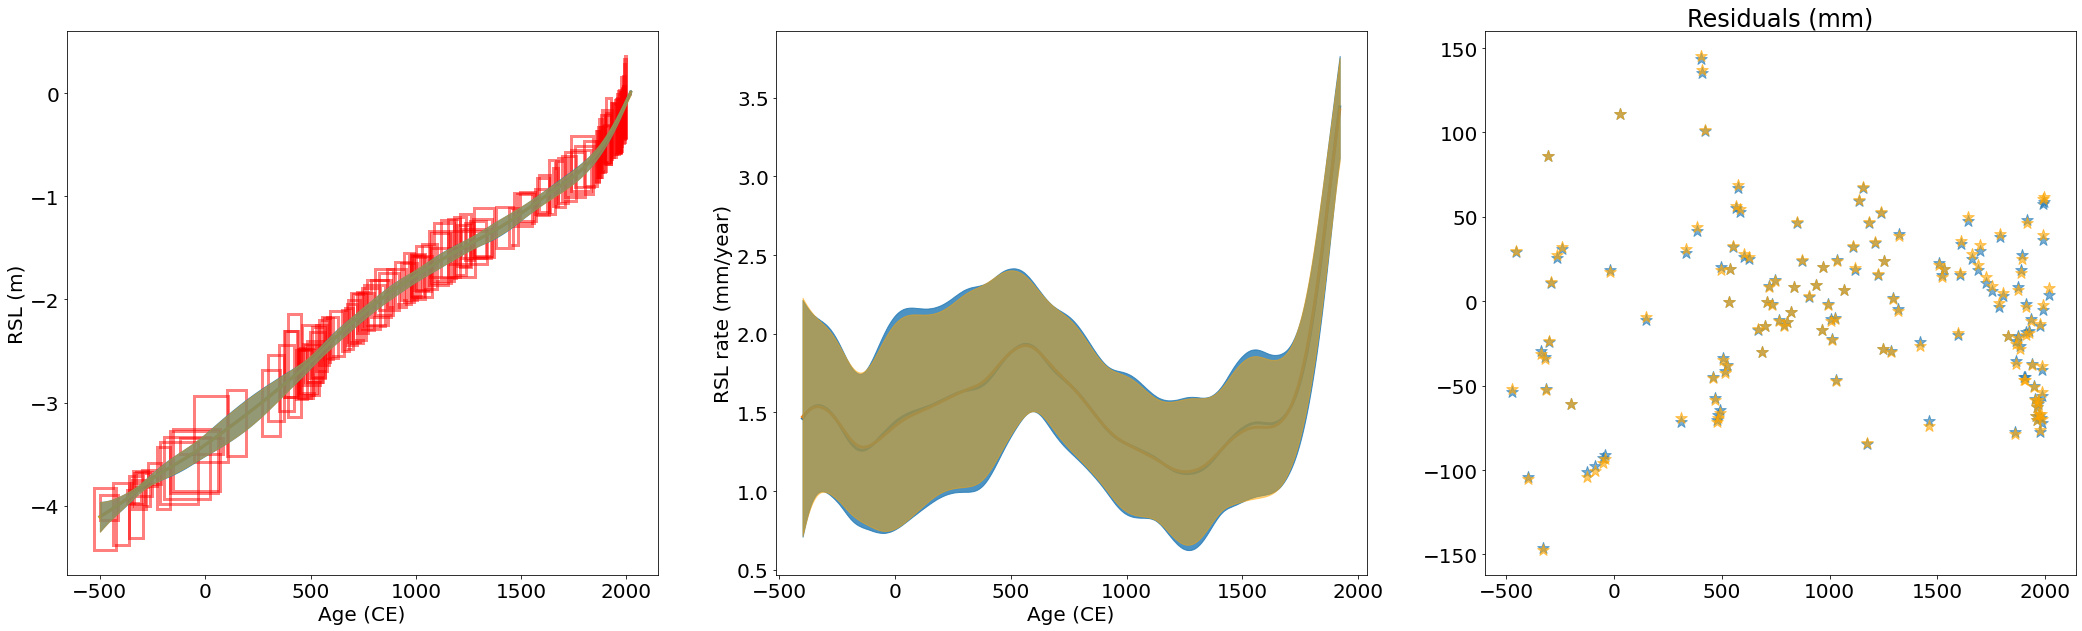

In [51]:
#-----plotting---------
fig= plt.figure(figsize=(36, 10))
ax = plt.subplot(131)
PSTHM.plot_uncertainty_boxes(NJ_rsl_age,NJ_rsl, NJ_rsl_age_2sd,NJ_rsl_2sd,ax=ax)

plt.plot(ashe_rsl_time,ashe_mean_rsl,linewidth=3)
plt.plot(x_test.detach().numpy(),c_kernel_y_mean.detach().numpy(),linewidth=3,color='orange',alpha=0.8)

plt.fill_between(
            ashe_rsl_time,  # plot the two-sigma uncertainty about the mean
            (ashe_mean_rsl - 2.0 * ashe_sd),
            (ashe_mean_rsl + 2.0 * ashe_sd),
            color="C0",
            alpha=0.8,zorder=10)
ax.fill_between(
            x_test.detach().numpy(),  # plot the two-sigma uncertainty about the mean
            (c_kernel_y_mean - 2.0 * c_kernel_sd).detach().numpy(),
            (c_kernel_y_mean + 2.0 * c_kernel_sd).detach().numpy(),
            color="orange",
            alpha=0.4,zorder=10)

ax = plt.subplot(132)
ax.plot(rsl_rate_time,ashe_rsl_rate*1000,linewidth=3)
ax.fill_between(
            rsl_rate_time,  # plot the two-sigma uncertainty about the mean
            (ashe_rsl_rate - 2.0 * ashe_rsl_rate_sd)*1000,
            (ashe_rsl_rate + 2.0 * ashe_rsl_rate_sd)*1000,
            color="C0",
            alpha=0.8,zorder=10)

plt.plot(rsl_time,c_kernel_rsl_rate*1000,linewidth=3)
ax.fill_between(
            rsl_time,  # plot the two-sigma uncertainty about the mean
            (c_kernel_rsl_rate - 2.0 * c_kernel_rsl_rate_sd)*1000,
            (c_kernel_rsl_rate + 2.0 * c_kernel_rsl_rate_sd)*1000,
            color="orange",
            alpha=0.5,zorder=10)

plt.xlabel('Age (CE)')
plt.ylabel('RSL rate (mm/year)')


ax = plt.subplot(133)
f_ashe = interpolate.interp1d(ashe_rsl_time,ashe_mean_rsl)
plt.scatter(X,(y-f_ashe(X))*1000,s=150,marker='*',color='C0',alpha=0.6)
plt.scatter(X,(y-pred_y.detach().numpy())*1000,s=150,marker='*',color='orange',alpha=0.6)

plt.title('Residuals (mm)');

The resulting inference are pretty much the same! So now you know how to do empirical temporal Gaussian process (ET-GP in [Ashe et al., (2019)](https://www.sciencedirect.com/science/article/pii/S0277379118302130?casa_token=lkL4EQzNcYUAAAAA:PJwiPDwNVwAViJLzpkDEnATGd5B8nKAIi5mN-ls9ITH-EltM7n0XqY5xWIL29IwFA-NyGPPECw#fig3)). You can now start to define the GP kernels yourself! 

In [52]:
#Try it here!
